# **Segmentation des clients d'un site e-commerce**
*Sofia Chevrolat (Août 2020)*
___
Cette étude en deux notebooks vise à segmenter la base client d'Olist en exploitant leurs données clients anonymisées comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

___
_**Remerciements**:<br>
Merci à mon compagnon [J. Duplan](https://www.linkedin.com/in/julian-duplan-64844a41/) pour les discussions intéressantes.<br>
Merci également à mon mentor [Samia Drappeau](https://www.linkedin.com/in/samiadrappeau) pour les échanges d'idées, les conseils et les encouragements!_
___

Cette étude est organisée en 2 notebooks: 
- Notebook de nettoyage, feature engineering et analyse exploratoire
- Notebook de modélisation et segmentation

___
## Notebook 1 : Nettoyage, Feature Engineering et Analyse Exploratoire

Ce notebook est organisé comme suit:

**0. Mise en place**
- 0.1 Chargement des librairies et fonctions utiles
- 0.2 Chargement et description du jeu de données
- 0.3 Assemblage du jeux de données
    
**1. Nettoyage**
- 1.1 Correction orthographique et typologiques
- 1.2 Suppression des outliers
    * 1.2.1 Suppression des produits dont le poids indiqué est <= 0
    * 1.2.2 Suppression des erreurs de workflow
- 1.3 Suppression des features les moins renseignées
- 1.4 Suppression des observations intégralement vides
- 1.5 Suppression des valeurs NaN

**2. Ciblage des données**

**3. Feature Engineering**
- 3.1 Création de nouvelles features
- 3.2 Encodage
    * 3.2.1 One Hot Encoding
    * 3.2.2 Feature Hashing
- 3.3 Réassemblage du jeu de données

**4. Analyse exploratoire**
- 4.1 Grandeurs statistiques
    * 4.1.1 Tendance centrale
        * 4.1.1.1 Features qualitatives
        * 4.1.1.2 Features quantitatives
    * 4.1.2 Distribution des features
        * 4.1.2.1 Features qualitatives
        * 4.1.2.2 Features quantitatives
- 4.2 Étude des corrélations avec le panier moyen et les scores RFM
    * 4.2.1 Variables qualitatives
        * 4.2.1.1 Avec le panier moyen
        * 4.2.1.2 Avec les scores RFM
    * 4.2.2 Variables quantitatives
        * 4.2.2.1 Avec le panier moyen
        * 4.2.2.2 Avec les scores RFM
- 4.3 Étude métier
    * 4.3.1 Étude des clients
        * 4.3.1.1 Évolution du nombre de clients et de nouveaux clients
        * 4.3.1.2 Évolution de la répartition des clients par état
        * 4.3.1.3 Évolution de la distribution des scores RFM 
    * 4.3.2 Étude des commandes
        * 4.3.2.1 Évolution du nombre de commandes par an et par client
        * 4.3.2.2 Évolution de la part de commandes en CA par état
        * 4.3.2.3 Évolution de la répartition des catégories commandes par état

**5. Export des données**

**6. Conclusion**

___
### 0. MISE EN PLACE

Dans cette première étape, le cadre de travail est mis en place, c'est-à-dire :
- Les librairies et packages Python nécessaires sont chargés
- Les fonctions utiles sont définies
- Le jeu de données est chargé
___

___
#### 0.1 CHARGEMENT DES LIBRAIRIES ET FONCTIONS UTILES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import math
import re
import pandas as pd
import numpy as np
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import FeatureHasher

In [3]:
from sys import path
path.append("./Resources/functions")

import helper_functions as hf
import graphical_functions as gf

___
#### 0.2 CHARGEMENT ET DESCRIPTION DU JEU DE DONNÉES

In [4]:
customers = pd.read_csv("./Resources/datasets/olist_customers_dataset.csv",
                        sep=",")
geolocation = pd.read_csv("./Resources/datasets/olist_geolocation_dataset.csv",
                          sep=",")
order_items = pd.read_csv("./Resources/datasets/olist_order_items_dataset.csv",
                          sep=",")
order_payments = pd.read_csv("./Resources/datasets/olist_order_payments_dataset.csv",
                             sep=",")
order_reviews = pd.read_csv("./Resources/datasets/olist_order_reviews_dataset.csv",
                            sep=",")
orders = pd.read_csv("./Resources/datasets/olist_orders_dataset.csv",
                     sep=",")
products = pd.read_csv("./Resources/datasets/olist_products_dataset.csv",
                       sep=",")
sellers = pd.read_csv("./Resources/datasets/olist_sellers_dataset.csv",
                      sep=",")
pdt_cat_i8n = pd.read_csv("./Resources/datasets/product_category_name_translation.csv",
                          sep=",")

In [5]:
hf.describe_dataset({'Customers':[customers, "Clients"],
                     'Geolocation': [geolocation, "Localisation"],
                     'Order items': [order_items, "Articles commandés"],
                     'Order payments' : [order_payments, "Paiements commandes"],
                     'Order reviews': [order_reviews, "Avis commandes"],
                     'Orders':[orders, "Commandes"],
                     'Products': [products, "Produits"],
                     'Sellers': [sellers, "Vendeurs"],
                     'Product Category Name Translation':[pdt_cat_i8n,
                                                          "Traduction des noms de catégorie"]})

Les données se décomposent en 9 fichier(s): 



Nom du fichier  Nb de lignes  Nb de colonnes  \
1                          Customers         99441               5   
2                        Geolocation       1000163               5   
3                        Order items        112650               7   
4                     Order payments        103886               5   
5                      Order reviews        100000               7   
6                             Orders         99441               8   
7                           Products         32951               9   
8                            Sellers          3095               4   
9  Product Category Name Translation            71               2   

                        Description  
1                           Clients  
2                      Localisation  
3                Articles commandés  
4               Paiements commandes  
5                    Avis commandes  
6                         Commandes  
7                          Produits  
8                          Vendeurs  
9  Traduction des noms de catégorie

Ces fichiers sont reliés comme suit : 

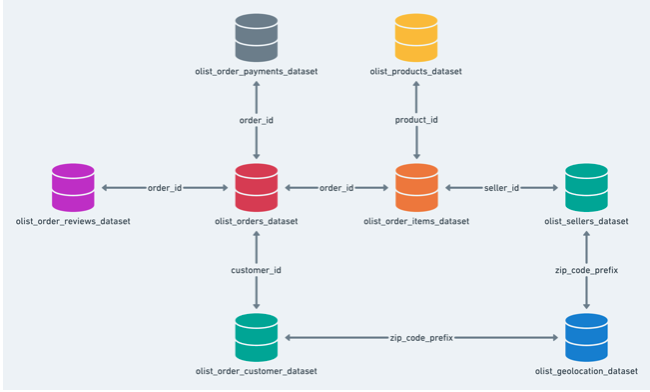

- Une commande comporte : 
    - informations internes
    - **<u>un client</u>**
    - un mode de paiement
    - **<u>des articles</u>**
    - un avis
    
    
- Un article comporte : 
    - informations internes
    - **<u>un vendeur</u>**
    
    
- Un client comporte : 
    - informations internes
    - géolocalisation
    
    
- Un vendeur comporte : 
    - informations internes
    - géolocalisation

Dans cette étude, on s'intéresse uniquement aux clients. Nous n'allons donc pas nous intéresser à la table des vendeurs.

Les informations de géolocalisation ne seront pas non plus utilisées car les informations d'adresse (ville, état) devraient suffire pour une segmentation client.

___
#### 0.3 ASSEMBLAGE DU JEU DE DONNÉES

On va réaliser plusieurs jointures pour obtenir un jeu de données complet en une seule DataFrame.

In [6]:
# Product information

full_products = order_items.join(products.set_index("product_id"),
                                 on="product_id")

In [7]:
# Order information

full_orders = orders.join(order_reviews.set_index("order_id"),
                          on='order_id')\
                    .join(order_payments.set_index("order_id"),
                          on='order_id')\
                    .join(full_products.set_index("order_id"),
                          on='order_id')

In [8]:
# Full data set with orders, products and clients

full_dataset = full_orders.join(customers.set_index("customer_id"),
                                on="customer_id")

Description du jeu de données obtenu :

In [9]:
hf.describe_dataset({'Full dataset':[full_dataset, "Full dataset"]})

Les données se décomposent en 1 fichier(s): 



Nom du fichier  Nb de lignes  Nb de colonnes   Description
1   Full dataset        119151              36  Full dataset

___
### 1. NETTOYAGE

___
#### 1.1 CORRECTIONS ORTHOGRAPHIQUES ET TYPOLOGIQUES

In [10]:
# Correcting misspelled column names

full_dataset.rename(columns={"product_description_lenght":"product_description_length",
                             "product_name_lenght":"product_name_length"}, inplace=True)

In [11]:
# Converting to string

full_dataset["product_category_name"] = full_dataset\
                                        .loc[:, "product_category_name"].astype("str")
full_dataset["customer_zip_code_prefix"] = full_dataset["customer_zip_code_prefix"]\
                                           .astype(str)

In [12]:
# Converting to datetime

cols_to_timestamp = ["order_approved_at",
                     "order_delivered_carrier_date",
                     "order_delivered_customer_date",
                     "order_estimated_delivery_date",
                     "order_purchase_timestamp",
                     "review_answer_timestamp",
                     "review_creation_date",
                     "shipping_limit_date"]

for col in cols_to_timestamp:
    full_dataset[col] = pd.to_datetime(full_dataset[col],
                                       format='%Y-%m-%d %H:%M:%S')

In [13]:
# Deleting linebreaks

full_dataset = full_dataset.replace('\n', '', regex=True)

___
#### 1.2 SUPPRESSION DES OUTLIERS

##### _<u>1.2.1 Suppression des produits dont le poids indiqué est nul ou négatif</u>_

In [14]:
# Deleting products that have a weight <= 0

full_dataset = full_dataset[full_dataset["product_weight_g"] > 0]
full_dataset = full_dataset[full_dataset["product_height_cm"] > 0]
full_dataset = full_dataset[full_dataset["product_width_cm"] > 0]
full_dataset = full_dataset[full_dataset["product_length_cm"] > 0]

##### _<u>1.2.2 Suppression des erreurs de workflow</u>_

In [15]:
# Deleting canceled orders that are marked as delivered

full_dataset = full_dataset[~((full_dataset["order_status"]!="canceled") \
                              & \
                              (full_dataset["order_approved_at"].isna()))]

In [16]:
# Deleting orders with incoherent event flow :
# 1) order_approved_at < order_delivered_carrier_date < order_delivered_customer_date 
#    < review_creation_date < review_answer_timestamp
# 2) order_approved_at < shipping_limit_date 

_order_approved_at_

In [17]:
# Deleting orders where order_approved_at < order_delivered_carrier_date

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                              > \
                              full_dataset["order_delivered_carrier_date"])]

In [18]:
# Deleting orders where order_approved_at < order_delivered_customer_date

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                              > \
                              full_dataset["order_delivered_customer_date"])]

In [19]:
# Deleting orders where order_approved_at < review_creation_date

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                              > \
                              full_dataset["review_creation_date"])]

In [20]:
# Deleting orders where order_approved_at < review_answer_timestamp

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                             > \
                             full_dataset["review_answer_timestamp"])]

In [21]:
# Deleting orders where order_approved_at < shipping_limit_date

full_dataset = full_dataset[~(full_dataset["order_approved_at"] \
                              > \
                              full_dataset["shipping_limit_date"])]

_order_delivered_carrier_date_

In [22]:
# Deleting orders where order_delivered_carrier_date < order_delivered_customer_date

full_dataset = full_dataset[~(full_dataset["order_delivered_carrier_date"] \
                              > \
                              full_dataset["order_delivered_customer_date"])]

In [23]:
# Deleting orders where order_delivered_carrier_date < review_creation_date

full_dataset = full_dataset[~(full_dataset["order_delivered_carrier_date"] \
                              > \
                              full_dataset["review_creation_date"])]

_order_delivered_customer_date_

In [24]:
# Deleting orders where order_delivered_customer_date < review_creation_date

full_dataset = full_dataset[~(full_dataset["order_delivered_customer_date"]\
                              >\
                              full_dataset["review_creation_date"])]

In [25]:
# Deleting orders where order_delivered_customer_date < review_answer_timestamp

full_dataset = full_dataset[~(full_dataset["order_delivered_customer_date"] \
                              > \
                              full_dataset["review_answer_timestamp"])]

_review_creation_date_

In [26]:
# Deleting orders where review_creation_date < review_answer_timestamp

full_dataset = full_dataset[~(full_dataset["review_creation_date"] \
                              > \
                              full_dataset["review_answer_timestamp"])]

___
#### 1.3 SUPPRESSION DES FEATURES LES MOINS RENSEIGNÉES

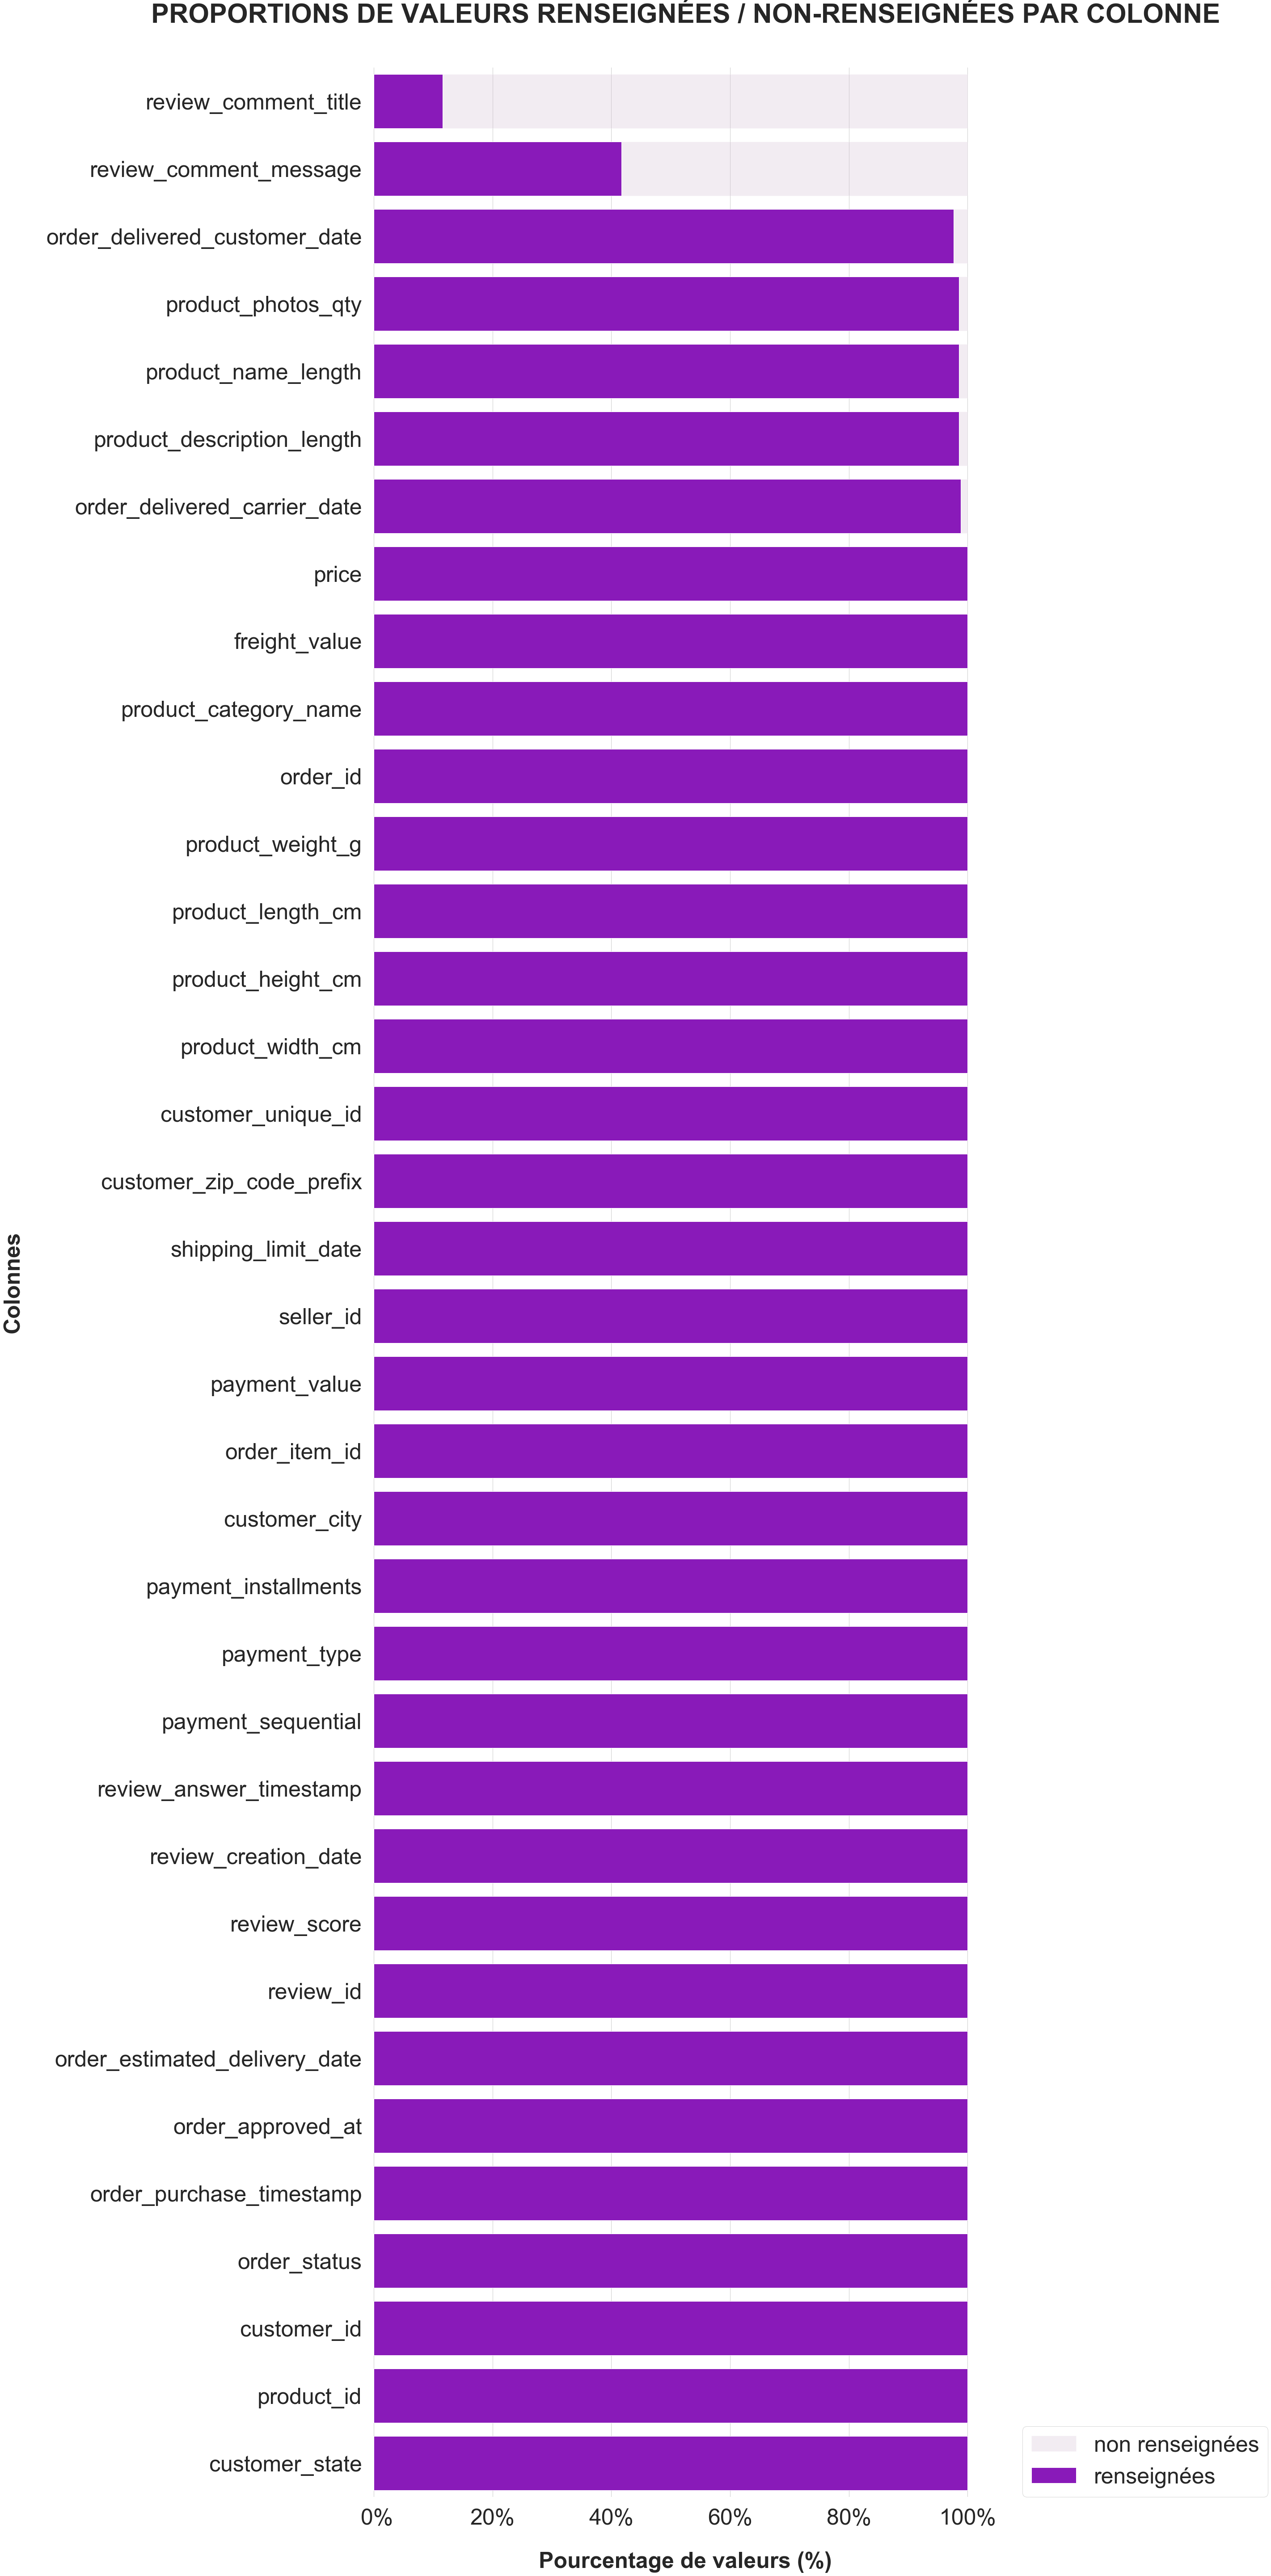

In [27]:
# Visualising filling rates for each column

gf.plot_percentage_missing_values_for(full_dataset,
                                      25, 100)

L'écrasante majorité des features sont très bien renseignées (taux de remplissage > 90%).

Afin d'avoir un jeu de données aussi qualitatif que possible, les colonnes considérées vont être restreintes 
à celles dont le taux de données non renseignées est inférieur à 5%.

In [28]:
missing_percent_df = hf.get_missing_values_percent_per(full_dataset)\
                       .rename(columns={"Percent Missing":"PercentMissing"})

In [29]:
columns_selected = [col \
                    for col \
                    in full_dataset.columns \
                    if missing_percent_df.loc[col,"PercentMissing"] < 5]

In [30]:
full_dataset = full_dataset[columns_selected]

___
#### 1.4 SUPPRESSION DES OBSERVATIONS INTÉGRALEMENT VIDES

In [31]:
# Dropping all rows that are entirely empty. There are no empty columns.

full_dataset = full_dataset.dropna(how='all', axis=1)

___
#### 1.5 SUPPRESSION DES VALEURS NAN

Leur nombre étant très faible sur les features conservées, on supprime les lignes présentant des valeurs NaN.

In [32]:
# Keeping only products with freight value

full_dataset = full_dataset[full_dataset["freight_value"].notna()]

In [33]:
# Keeping only products where order has been approved

full_dataset = full_dataset[full_dataset["order_approved_at"].notna()]

In [34]:
# Keeping only products where status is delivered
# and carrier delivery date is filled out

full_dataset = full_dataset[~(full_dataset["order_delivered_carrier_date"].isna() \
                              &
                              full_dataset["order_status"].isin(["delivered"]))]

In [35]:
# Keeping only products where status is delivered 
# and customer delivery date is filled out

full_dataset = full_dataset[~(full_dataset["order_delivered_customer_date"].isna() \
                              &
                              full_dataset["order_status"].isin(["delivered"]))]

In [36]:
# Keeping only products where a payment has been made

full_dataset = full_dataset[full_dataset["payment_installments"].notna()]

In [37]:
# Keeping only products with a known category

full_dataset = full_dataset[full_dataset["product_category_name"] != "nan"]

___
### 2 CIBLAGE DU JEU DE DONNÉES

On ne s'intéresse qu'aux données à partir de janvier 2017.
Nous allons donc conserver uniquement les données à partir de cette date.

In [38]:
full_dataset = full_dataset[full_dataset["order_purchase_timestamp"]\
                            .dt.year != 2016]

___
### 3. FEATURE ENGINEERING

___
#### 3.1 CRÉATION DE NOUVELLES FEATURES

Le but de l'analyse étant de pouvoir effectuer une segmentation client exploitable par la cellule marketing, nous allons retravailler nos features pour en dégager des grandeurs d'intérêt, en particulier :
   - La date du 1er achat (<i>first_order_date</i>)
   - La date du dernier achat (<i>last_order_date</i>)
   - Le nombre de commandes (<i>nb_orders</i>)
   - Le nombre moyen d'articles par commande (<i>nb_items_order</i>)
   - Le nombre de commandes annulées (<i>canceled_orders</i>)
   - Le nombre moyen de paiements par commande (<i>payment_installments</i>)
   - Le nombre moyen de moyens de paiements par commande (<i>payment_sequential</i>)
   - Le type de paiement le plus souvent utilisé (<i>payment_type</i>)
   - Le panier moyen (<i>average basket</i>)
   - Les frais de port moyens (<i>freight_value</i>)
   - La catégorie de produit où le client achète le plus (<i>product_category_name</i>)
   - Les dimensions moyennes des produits achetés (<i>product_volume_cm3</i>, <i>product_weight_g</i>)
   - La satisfaction moyenne du client (<i>review_score</i>)

Nous allons également calculer les scores RFM sur la base des critères suivants : 
- **Score de récence : caractérisation de la récence du dernier achat du client**

Le maximum entre "10 - le nombre de mois écoulés depuis le dernier achat du client" et 1 si le client a déjà effectué un achat, 0 sinon.

- **Score de fréquence : caractérisation de la fréquence d'achat du client**

Le maximum entre "le nombre de commandes passées par le client (dans la limite de 10)" et 1 si le client a déjà effectué un achat, 0 sinon.

- **Score de montant : caractérisation du montant des commandes du client**

La valeur moyenne de toutes les commandes passées par le client exprimée en pourcentage de la valeur du panier moyen e-commerce au Brésil pour l'année en cours.

[Average basket for e-commerce in Brazil - years 2016 - 2019, projections 2020](https://www.statista.com/statistics/255337/average-b2c-e-commerce-sales-per-digital-buyer-in-brazil/)

In [39]:
# Average basket for e-commerce in Brazil

AVERAGE_BASKET = {2017:417, 2018:420}

In [40]:
customer_data_2017 = hf.get_exploitable_customer_data(full_dataset,
                                                      2017,
                                                      AVERAGE_BASKET[2017])

In [41]:
customer_data_2018 = hf.get_exploitable_customer_data(full_dataset,
                                                      2018,
                                                      AVERAGE_BASKET[2018])

Assemblage global pour la suite du feature engineering avec réindexation

In [42]:
customer_data = pd.concat([customer_data_2017.assign(year='2017'),
                           customer_data_2018.assign(year='2018')])

In [43]:
customer_data = customer_data.reset_index(drop=True)

___
#### 3.2 ENCODAGE

On laisse telles quelles les colonnes d'attributs numériques des produits, ainsi que les colonnes numériques présentant une ordinalité réelle (<i>payment_sequential</i> et <i>review_score</i>).

##### _<u>3.2.1 One Hot Encoding</u>_

**Pour les variables prenant peu de valeurs potentielles:**
- payment_type

In [44]:
cols_to_dummies = ["payment_type"]

customer_data = pd.concat([customer_data[["payment_type"]],
                           pd.get_dummies(customer_data, 
                                          columns=cols_to_dummies)],
                          axis=1)

##### _<u>3.2.2 Feature Hashing</u>_

**Pour les variables prenant un grand nombre de valeurs potentielles:**
    - customer_city
    - customer_state
    - product_category_name

In [45]:
cols_prefix = {"customer_city":"CLI_CITY",
               "customer_state":"CLI_STATE",
               "product_category_name":"PRODUCT_CAT"}

In [46]:
fh = FeatureHasher(n_features=6, input_type='string')

In [47]:
for col, pref_col in cols_prefix.items():
    hashed_features = fh.fit_transform(customer_data[col].astype("str"))
    hashed_features = hashed_features.toarray()
    hashed_df = pd.DataFrame(hashed_features)\
                .rename(columns={0:pref_col+"_0", 
                                 1:pref_col+"_1", 
                                 2:pref_col+"_2", 
                                 3:pref_col+"_3", 
                                 4:pref_col+"_4", 
                                 5:pref_col+"_5"})

    customer_data = pd.concat([customer_data, hashed_df], axis=1)

___
#### 3.3 RÉASSEMBLAGE DU JEU DE DONNÉES

Nouvelle séparation du jeu de données par an pour analyse

In [48]:
customer_data_2017 = customer_data[customer_data["year"] == '2017']\
                     .drop(columns=["year"])
customer_data_2018 = customer_data[customer_data["year"] == '2018']\
                     .drop(columns=["year"])

Description du jeu de données final de travail

In [49]:
hf.describe_dataset({'Customers 2017': [customer_data_2017,
                                        "Customers 2017"],
                     'Customers 2018': [customer_data_2018,
                                        "Customers 2018"]})

Les données se décomposent en 2 fichier(s): 



Nom du fichier  Nb de lignes  Nb de colonnes     Description
1  Customers 2017         41083              52  Customers 2017
2  Customers 2018         46387              52  Customers 2018

___
### 4. ANALYSE EXPLORATOIRE

___
#### 4.1 GRANDEURS STATISTIQUES

In [50]:
qualitative_cols = customer_data.select_dtypes(include="object")\
                                .columns.drop(["customer_id", "year"]).to_list()

In [51]:
quantitative_cols = ["nb_orders",
                     "nb_items_order",
                     "canceled_orders",
                     "payment_installments",
                     "payment_sequential",
                     "average_basket",
                     "freight_value",
                     "product_volume_cm3",
                     "product_weight_g",
                     "review_score",
                     "R_score",
                     "F_score",
                     "M_score"]

In [52]:
CLI_CITY_cols = [col for col in full_dataset if col.startswith('CLI_CITY_')]
CLI_STATE_cols = [col for col in full_dataset if col.startswith('CLI_STATE_')]
PRODUCT_CAT_cols = [col for col in full_dataset if col.startswith('PRODUCT_CAT_')]

##### _<u>4.1.1 Tendance centrale</u>_

###### 4.1.1.1 Features qualitatives

In [53]:
customer_data[qualitative_cols].mode().T.rename(columns={0:"Mode"})

Mode
payment_type               credit_card
customer_city                sao paulo
customer_state                      SP
product_category_name  cama_mesa_banho

Les acheteurs proviennent principalement de la ville de São Paulo, dans l'état de São Paulo. 

Ils achètent essentiellement des produits de la catégorie "chambre-salle à manger-salle de bain", et paient majoritairement par carte de crédit.

###### 4.1.1.2 Features quantitatives

In [54]:
pd.concat([customer_data[quantitative_cols].median(),
           customer_data[quantitative_cols].mean(),
           customer_data[quantitative_cols].var(),
           customer_data[quantitative_cols].std(),
           customer_data[quantitative_cols].std()/customer_data[quantitative_cols].mean()], axis=1)\
          .rename(columns={0:"Médiane",
                           1:"Moyenne",
                           2:"Variance",
                           3:"Écart-type",
                           4:"Coeff de variation"})

Médiane       Moyenne      Variance    Écart-type  \
nb_orders                1.00      1.000000  0.000000e+00      0.000000   
nb_items_order           1.00      1.201246  5.819258e-01      0.762841   
canceled_orders          1.00      0.864571  1.170895e-01      0.342183   
payment_installments     1.00      1.276429  1.651774e+00      1.285213   
payment_sequential       1.00      1.022396  3.720319e-02      0.192881   
average_basket         109.19    207.525237  4.202159e+05    648.240600   
freight_value           16.25     20.004328  2.441507e+02     15.625323   
product_volume_cm3    6480.00  15188.365215  5.421172e+08  23283.410886   
product_weight_g       700.00   2091.846197  1.390216e+07   3728.559482   
review_score             5.00      4.215891  1.502539e+00      1.225781   
R_score                  3.00      3.935052  7.773314e+00      2.788066   
F_score                  1.00      0.995701  4.280187e-03      0.065423   
M_score                 26.00     43.904127  5.309795e+03     72.868342   

                      Coeff de variation  
nb_orders                       0.000000  
nb_items_order                  0.635041  
canceled_orders                 0.395784  
payment_installments            1.006882  
payment_sequential              0.188656  
average_basket                  3.123671  
freight_value                   0.781097  
product_volume_cm3              1.532977  
product_weight_g                1.782425  
review_score                    0.290753  
R_score                         0.708521  
F_score                         0.065706  
M_score                         1.659715

Ces grandeurs permettent de faire ressortir certains informations clés : 
- Les clients : 
    * ne commandent qu'une fois (nb_orders : médiane = moyenne = 1 et variance = écart-type = coeff de variation = 0)
    * paient en une fois et avec 1 seul moyen de paiement pour 50% d'entre eux
    * achètent pour un panier moyen autour de 207 reais, soit un panier moyen très inférieur au panier moyen e-commerce du pays, qui se situe autour de 400 reais.
    * sont très satisfaits de leurs achats (médiane = 5, moyenne = 4)

- Les produits achetés : 
    * sont de volume (15258cm3) et de poids moyens (2.1kg).

##### _<u>4.2.1 Distribution</u>_

###### 4.2.1.1 Features qualitatives

In [55]:
gf.plot_qualitative_dist(customer_data[["payment_type",
                                        "customer_state",
                                        "product_category_name",
                                        "year"]], 100, 100)

Les distributions sont globalement peu équilibrées sur l'ensemble du jeu de données.

###### 4.2.1.2 Features quantitatives

In [56]:
lorenzs, _ = hf.get_lorenzs_ginis(customer_data[["payment_sequential",
                                                 "payment_installments",
                                                 "average_basket",
                                                 "product_weight_g",
                                                 "product_volume_cm3",
                                                 "freight_value",
                                                 "R_score",
                                                 "F_score",
                                                 "M_score"]])

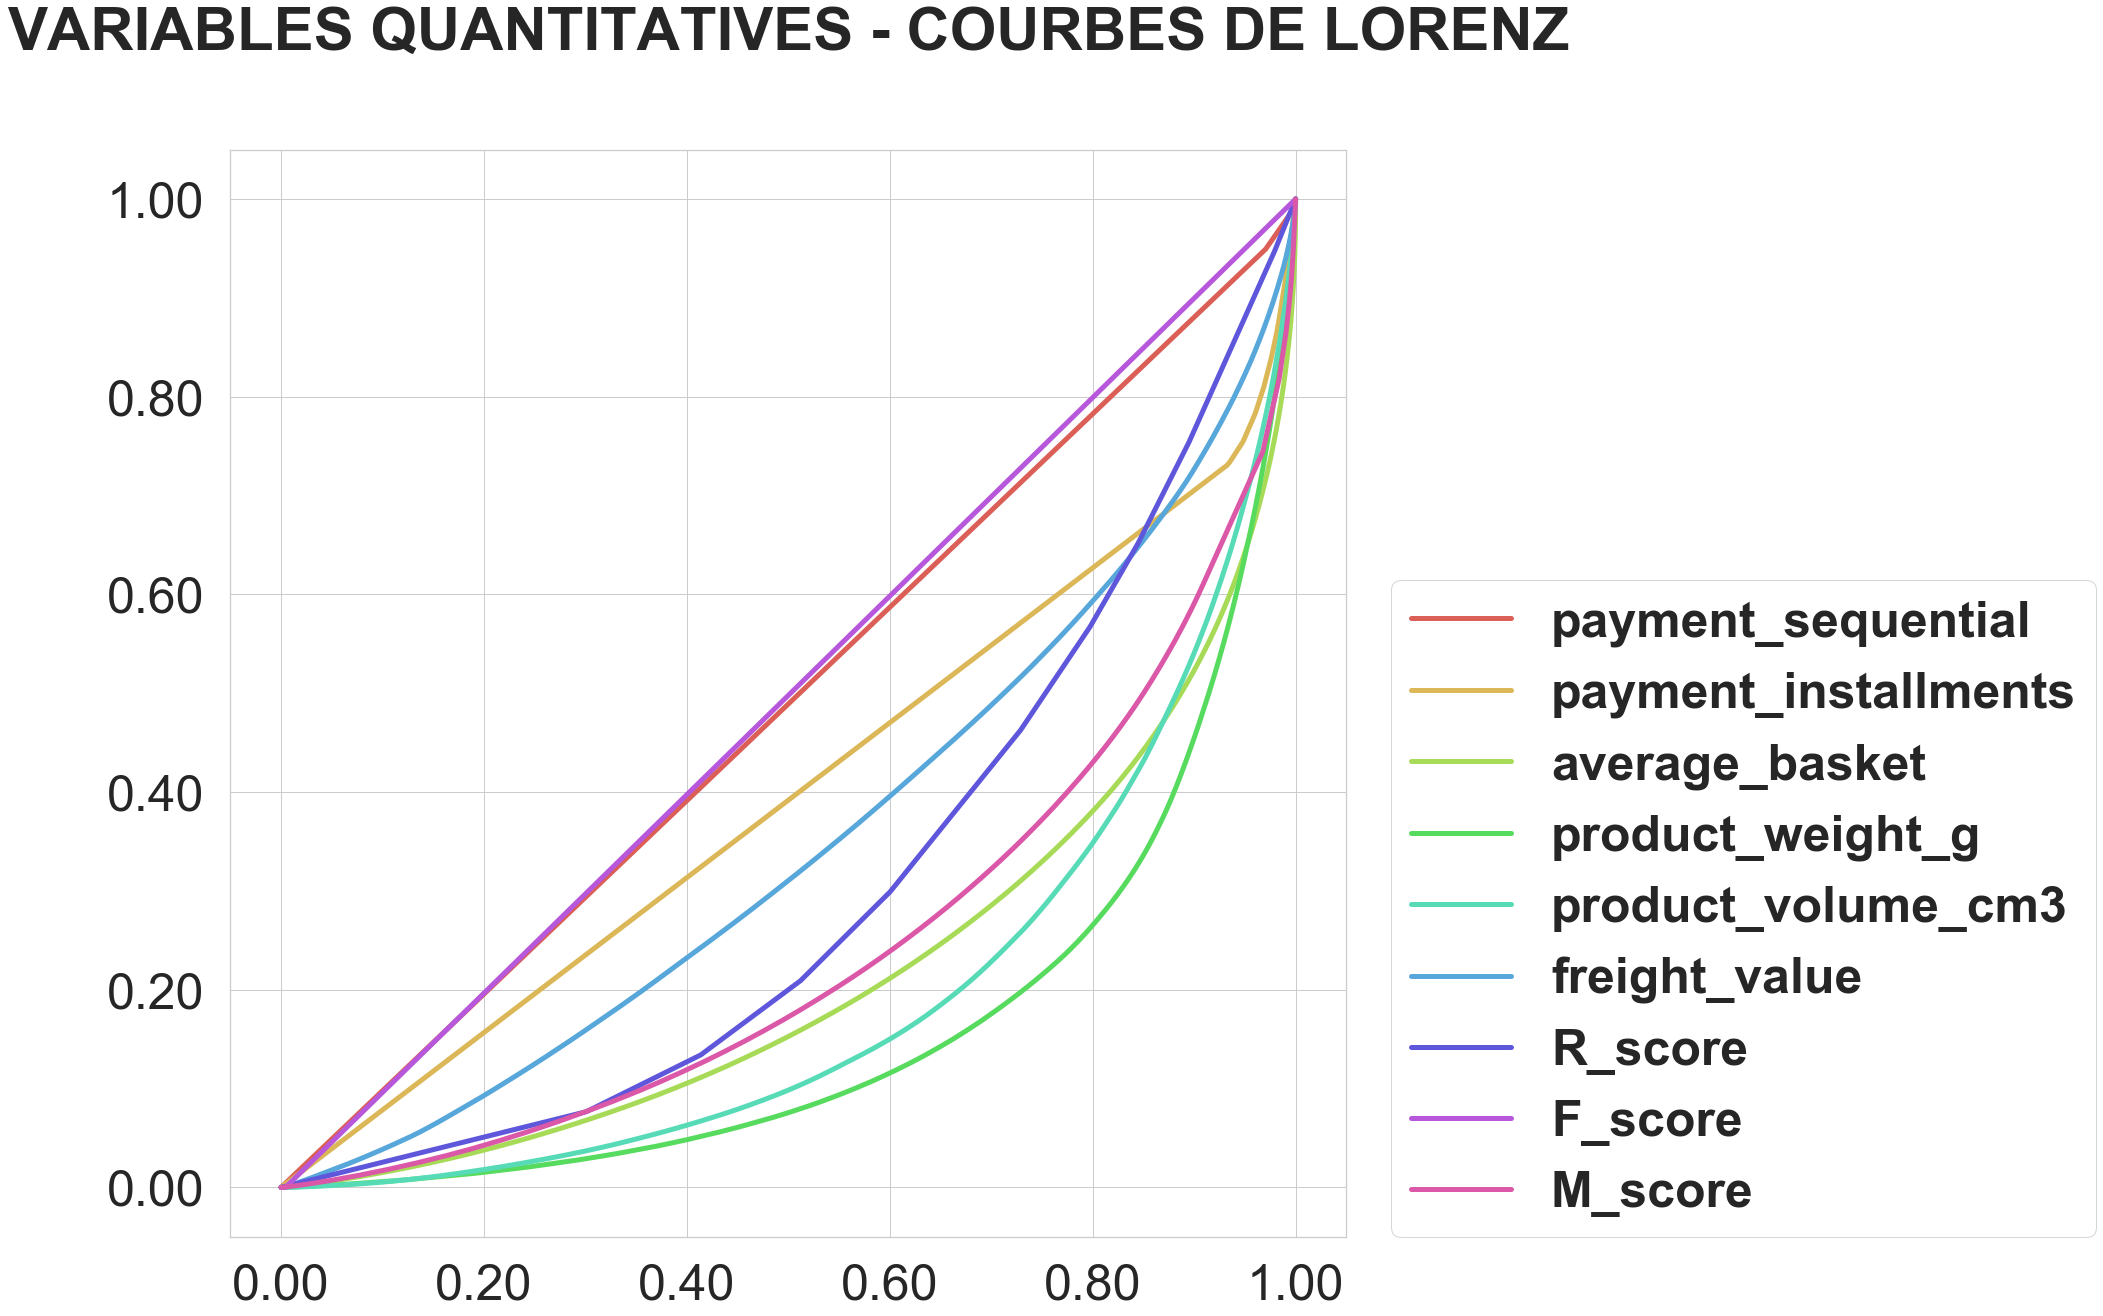

In [57]:
for col in lorenzs:
    lorenzs[col] = lorenzs[col].astype(float)
        
gf.plot_lorenz(lorenzs, 20, 20)

- La variable "payment_sequential" présente une distribution très égalitaire : la majeure partie des clients paient avec un seul moyen de paiement par commande.
- Le panier moyen présente une distribution inégalitaire.
- Le poids et le volume des produits varient beaucoup sur le jeu de données.
- Le score de fréquence présente une répartition très égalitaire, ce qui était attendu étant donné que la grosse majorité des clients n'ont passé qu'une seule commande.
- Le score de montant est celui des 3 qui présente la distribution la plus inégalitaire, miroir du panier moyen.

____
#### 4.2 ÉTUDE DES CORRÉLATIONS AVEC LE PANIER MOYEN ET LES SCORES RFM

##### _<u>4.2.1 Variables qualitatives</u>_

###### 4.2.1.1 Avec le panier moyen

In [58]:
hf.get_eta_squared(customer_data, qualitative_cols, "average_basket")

Coeff de corrélation
customer_city                      0.027051
product_category_name              0.022941
customer_state                     0.001642
payment_type                       0.000336

Aucune corrélation importante ne ressort entre les variables qualitatives et le panier moyen.

###### 4.2.1.2 Avec les scores RFM

<u>Recency score</u>

In [59]:
hf.get_eta_squared(customer_data, qualitative_cols, "R_score")

Coeff de corrélation
customer_city                      0.048322
product_category_name              0.013330
customer_state                     0.000569
payment_type                       0.000071

Aucune corrélation importante ne ressort entre les variables qualitatives et le score de récence.

<u>Frequency score</u>

In [60]:
hf.get_eta_squared(customer_data, qualitative_cols, "F_score")

Coeff de corrélation
customer_city                      0.022057
product_category_name              0.001759
customer_state                     0.000501
payment_type                       0.000043

Aucune corrélation importante ne ressort entre les variables qualitatives et le score de fréquence.

<u>Monetary score</u>

In [61]:
hf.get_eta_squared(customer_data, qualitative_cols, "M_score")

Coeff de corrélation
customer_city                      0.055694
product_category_name              0.050711
customer_state                     0.004470
payment_type                       0.001054

Aucune corrélation importante ne ressort entre les variables qualitatives et le score de montant.

Aucune corrélation majeure ne ressort de cette analyse.

#### _<u>4.2.2 Variables quantitatives</u>_

In [62]:
THRESHOLD = 0.25
TITLE_1 = "COEFFICIENTS DE CORRÉLATION DE SPEARMAN"
TITLE_2 = "P-VALEURS ASSOCIÉES"

interest_cols = quantitative_cols + \
                CLI_CITY_cols + \
                CLI_STATE_cols + \
                PRODUCT_CAT_cols

###### 4.2.2.1 Avec le panier moyen

/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/sofia/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


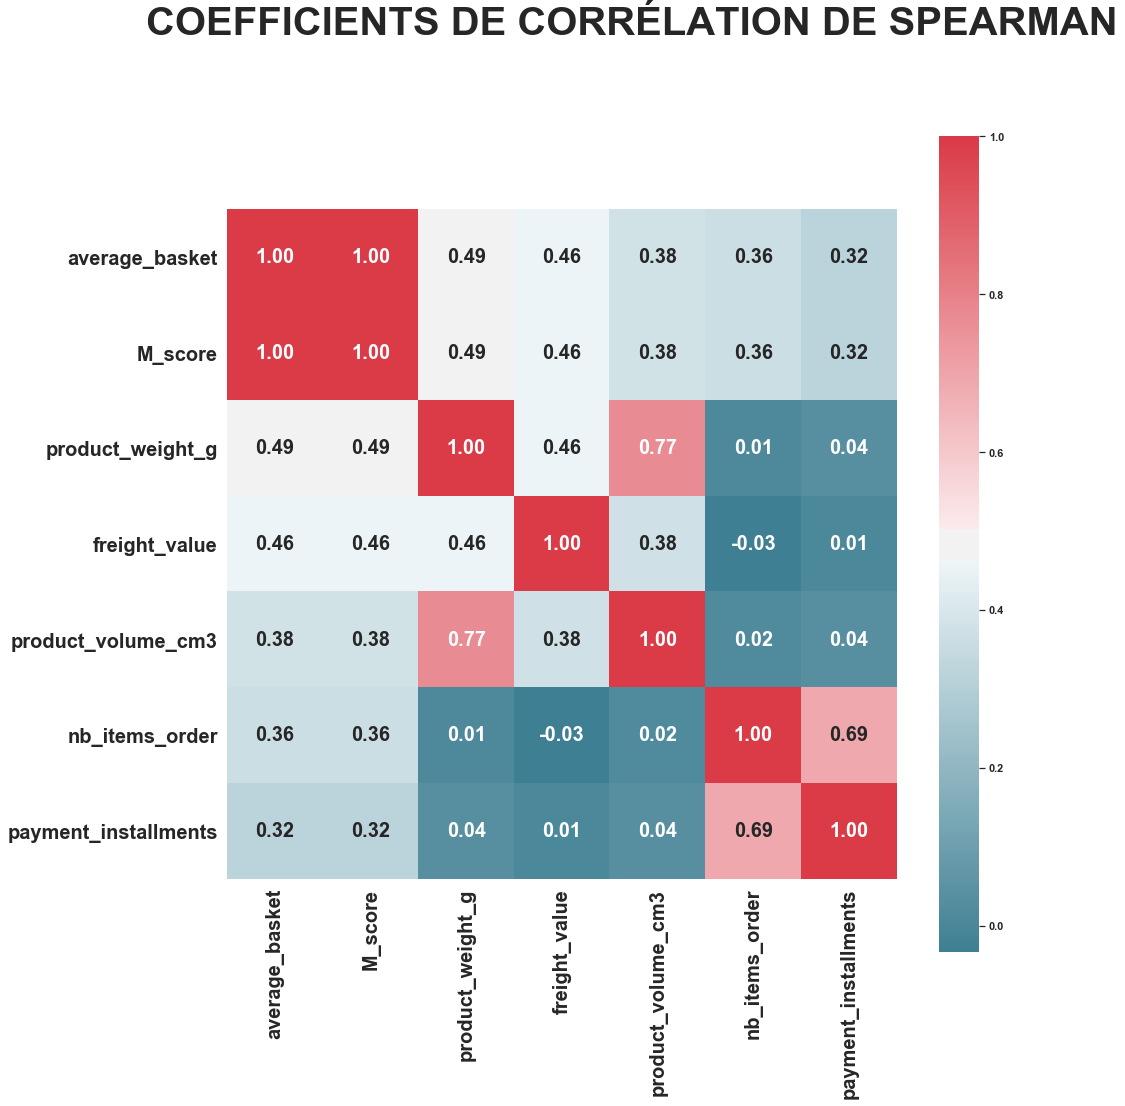

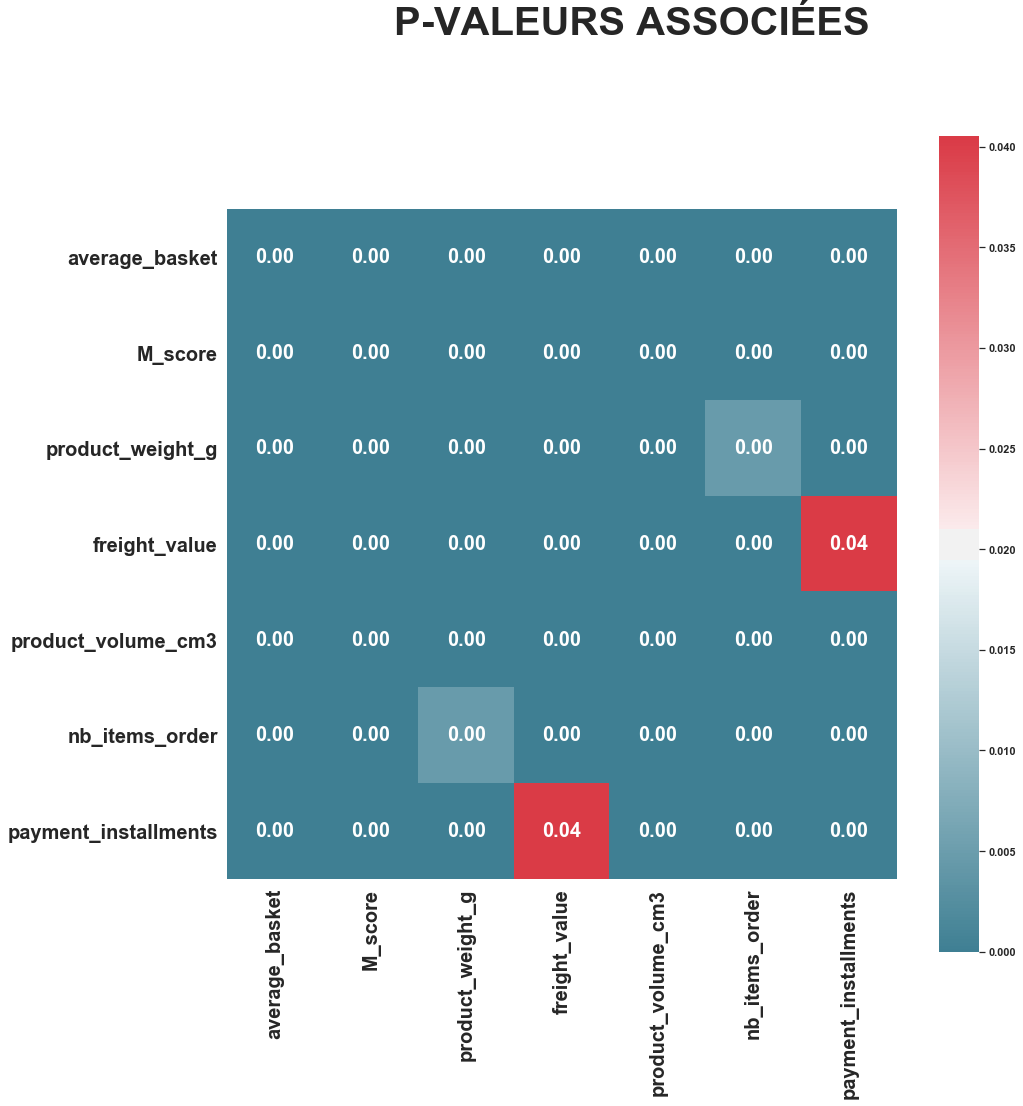

In [63]:
gf.plot_corr_p_value(customer_data,
                     interest_cols,
                     "average_basket",
                     THRESHOLD,
                     TITLE_1,
                     TITLE_2)

###### 4.2.2.2 Avec les scores RFM

<u>Recency score</u>

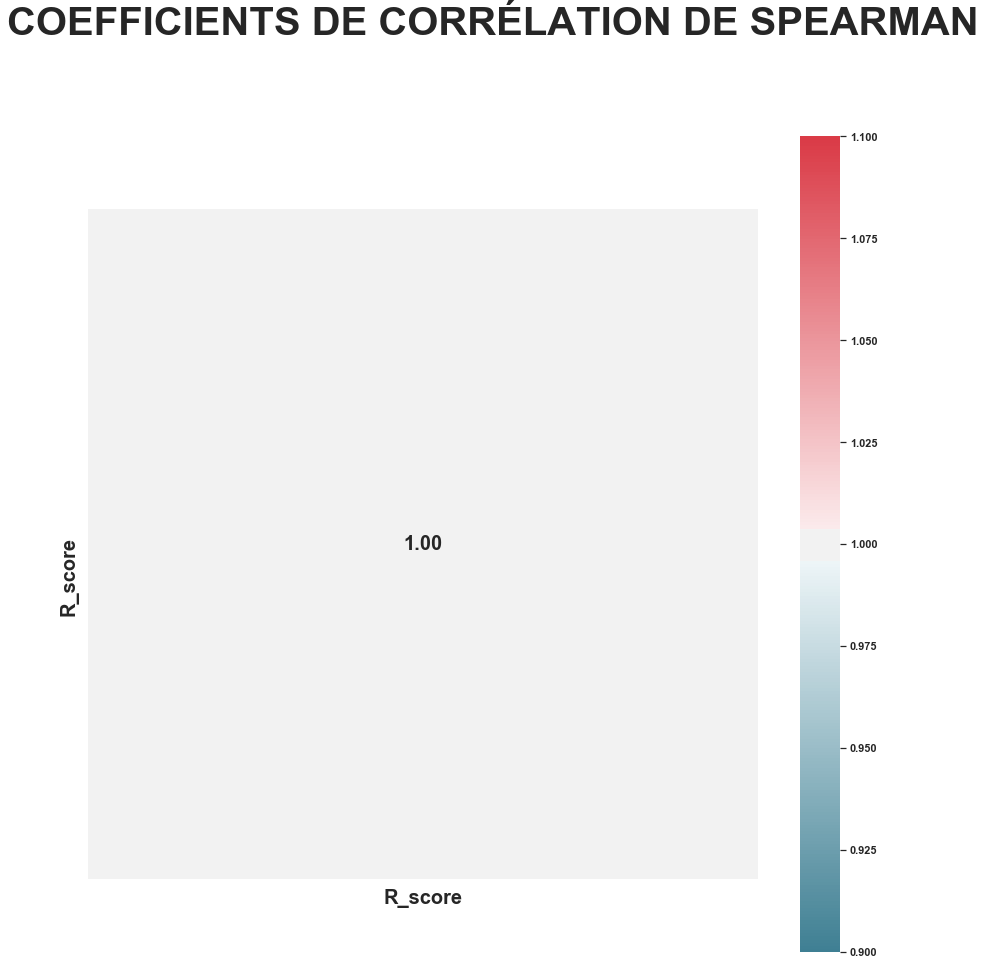

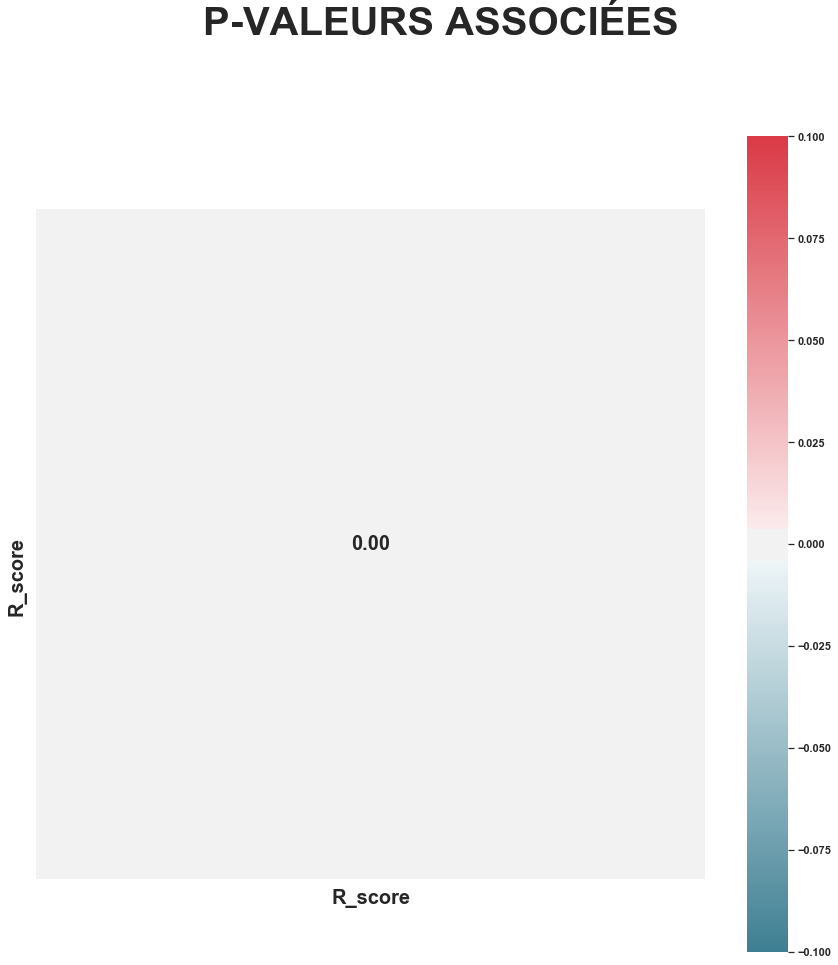

In [64]:
gf.plot_corr_p_value(customer_data,
                     interest_cols,
                     "R_score",
                     THRESHOLD,
                     TITLE_1,
                     TITLE_2)

<u>Frequency score</u>

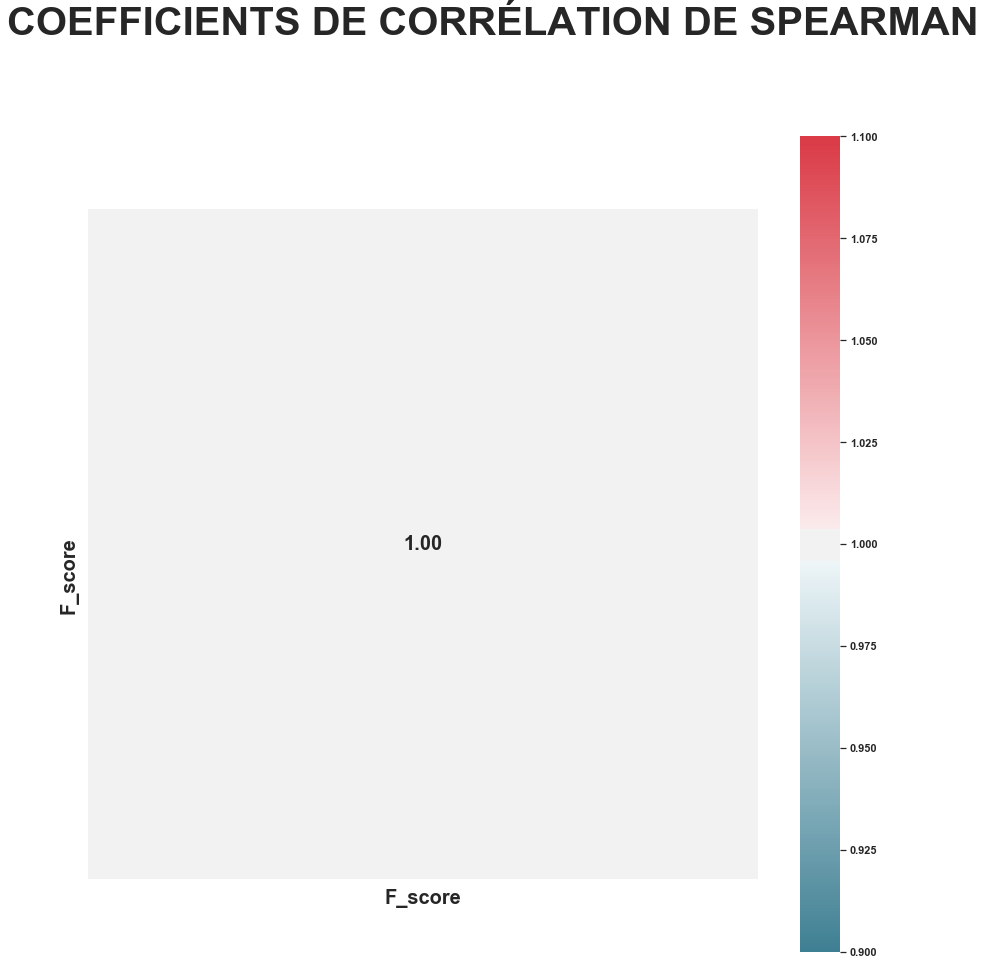

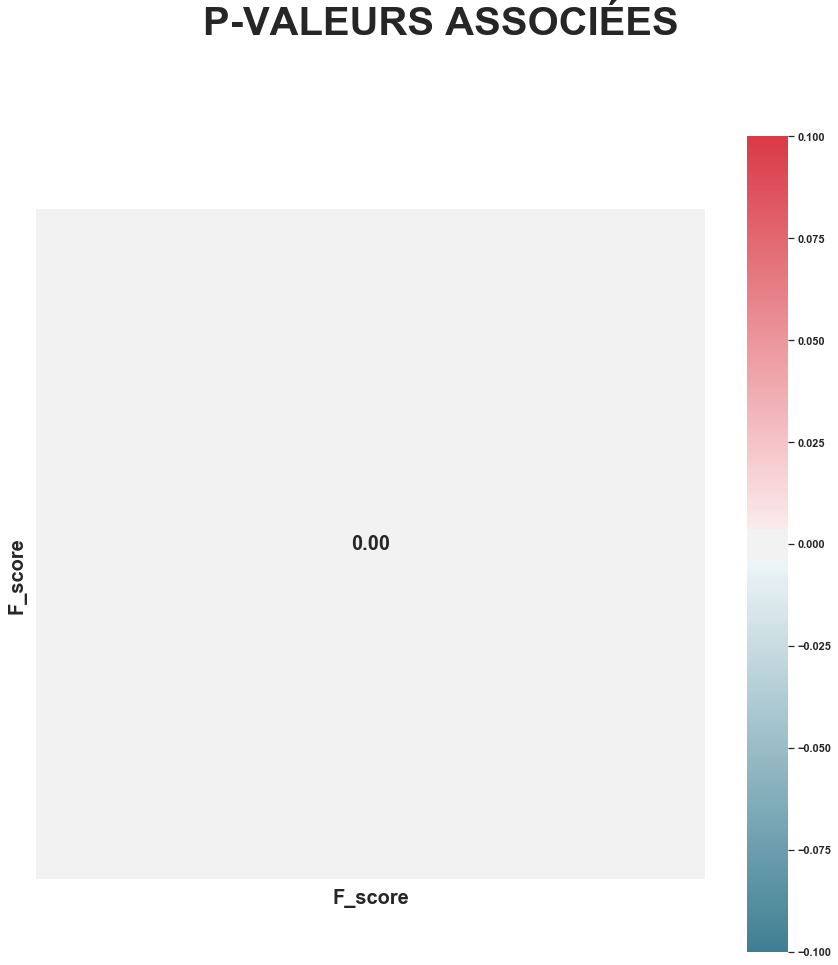

In [65]:
gf.plot_corr_p_value(customer_data,
                     interest_cols,
                     "F_score",
                     THRESHOLD,
                     TITLE_1,
                     TITLE_2)

Aucune corrélation ne ressort avec les scores R et F.

<u>Monetary score</u>

Les corrélations avec le panier moyen ont fait ressortir une corrélation maximale avec le monetary score.

____
#### 4.3 ANALYSE MÉTIER

##### _<u>4.3.1 Étude des clients</u>_

###### 4.3.1.1 Évolution du nombre de clients et de nouveaux clients

In [66]:
nb_clients_2017 = len(customer_data_2017)
clients_2017 = list(customer_data_2017["customer_id"])

nb_clients_2018 = len(customer_data_2018)

In [67]:
print("On comptait {} clients en 2017.".format(nb_clients_2017))
print("\n")
print("On comptait {} clients en 2018, \n\
       soit une augmentation de {:.2f}% par rapport à 2017.\n\
       Parmi ces clients, on comptait {} clients retours de 2017."\
      .format(nb_clients_2018, 
              (nb_clients_2018-nb_clients_2017)*100/nb_clients_2017,
              len(customer_data_2018[customer_data_2018["customer_id"].isin(clients_2017)])))

On comptait 41083 clients en 2017.


On comptait 46387 clients en 2018, 
       soit une augmentation de 12.91% par rapport à 2017.
       Parmi ces clients, on comptait 0 clients retours de 2017.


In [68]:
recap_df = customer_data.groupby("year").agg("count")\
                        .reset_index().rename(columns={"customer_id":"clients"})

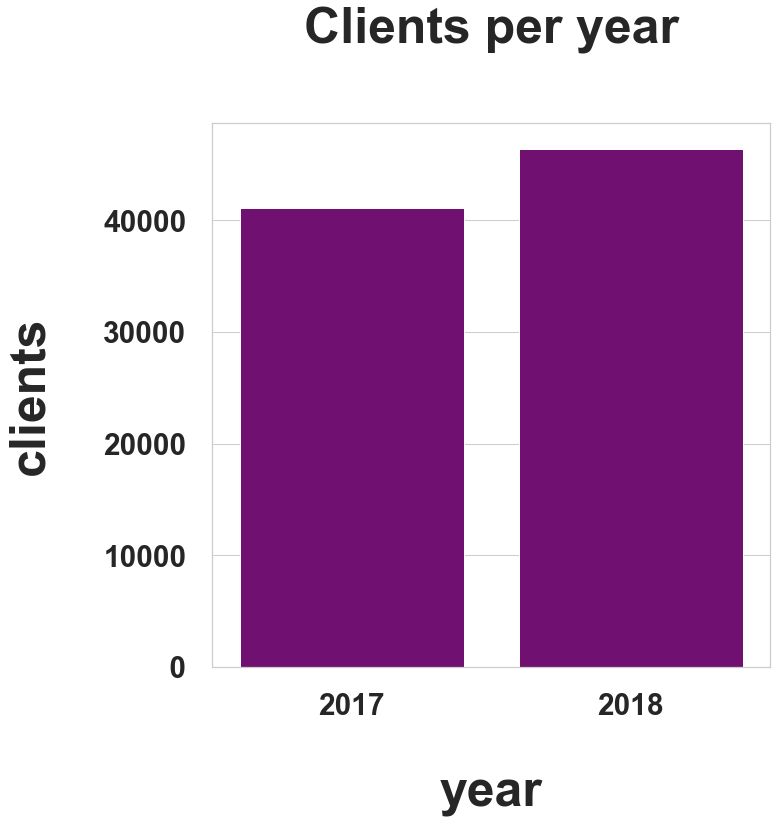

In [69]:
gf.plot_barplot(recap_df, "year", "clients", "Clients per year", 10, 10)

###### 4.3.1.2 Évolution de la répartition des clients par état

In [70]:
customer_data_years = {2017:customer_data_2017,
                       2018:customer_data_2018}

data_clients_state = pd.DataFrame(columns=["customer_state",
                                           "% of clients",
                                           "year"])

for year, data in customer_data_years.items():
    for customer_state, data_df in data.groupby("customer_state"):
        row = [customer_state,
               data_df["customer_id"].nunique()*100/data["customer_id"].nunique(),
               year]

        data_clients_state.loc[len(data_clients_state)] = row

In [71]:
sorted_data_clients_state = data_clients_state[data_clients_state["year"] == 2017]\
                            .rename(columns={"% of clients":"% of clients - 2017"})\
                            .drop(columns="year")\
                            .join(data_clients_state[data_clients_state["year"] == 2018]\
                                  .rename(columns={"% of clients":"% of clients - 2018"})\
                                  .drop(columns="year").set_index("customer_state"), on="customer_state")\
                            .sort_values(by=["% of clients - 2018",
                                             "% of clients - 2017"],
                                         ascending=False)

In [72]:
sorted_data_clients_state

customer_state  % of clients - 2017  % of clients - 2018
25             SP            40.045761            45.473947
10             MG            12.314096            11.567896
18             RJ            13.192805            11.466575
17             PR             5.135944             5.219135
22             RS             5.963537             5.152306
23             SC             3.831268             3.559187
4              BA             3.371224             3.132343
6              DF             2.049510             2.267877
8              GO             2.124967             1.901395
7              ES             2.137137             1.860435
15             PE             1.664922             1.573717
5              CE             1.399606             1.082200
12             MT             0.932259             0.890336
13             PA             1.100212             0.780391
11             MS             0.676679             0.709250
9              MA             0.766741             0.577748
14             PB             0.535501             0.502296
16             PI             0.477083             0.457025
19             RN             0.486819             0.448401
1              AL             0.399192             0.338457
24             SE             0.389455             0.271628
26             TO             0.301828             0.254382
20             RO             0.321301             0.206955
2              AM             0.165519             0.146593
3              AP             0.065721             0.073296
0              AC             0.114403             0.043116
21             RR             0.036511             0.043116

80% des états sont regroupés dans 7 états : "SP", "RJ", "MG", "RS", "PR", "SC", "BA".

In [73]:
biggest_states = list(sorted_data_clients_state.head(7)["customer_state"])

**Représentation graphique**

In [74]:
biggest_data = data_clients_state[data_clients_state["customer_state"]\
                                  .isin(biggest_states)].copy()
other_data = data_clients_state[~data_clients_state["customer_state"]\
                                 .isin(biggest_states)].copy()

In [75]:
other_data = other_data.groupby("year").agg("sum").reset_index()

In [76]:
other_data["customer_state"] = "OTHER"

In [77]:
other_data = other_data[["customer_state",
                         "% of clients",
                         "year"]]

In [78]:
states_data = pd.concat([biggest_data, other_data])\
              .reset_index(drop=True)

In [103]:
data_2017 = states_data[states_data["year"]==2017].drop(columns="year")\
            .set_index("customer_state")

data_2018 = states_data[states_data["year"]==2018].drop(columns="year")\
            .set_index("customer_state")

gf.plot_2_pie_charts(data_2017, data_2018, 20, 10, "Répartition Clients")

###### 4.3.1.3 Évolution de la distribution des scores RFM

_<u>Recency score</u>_

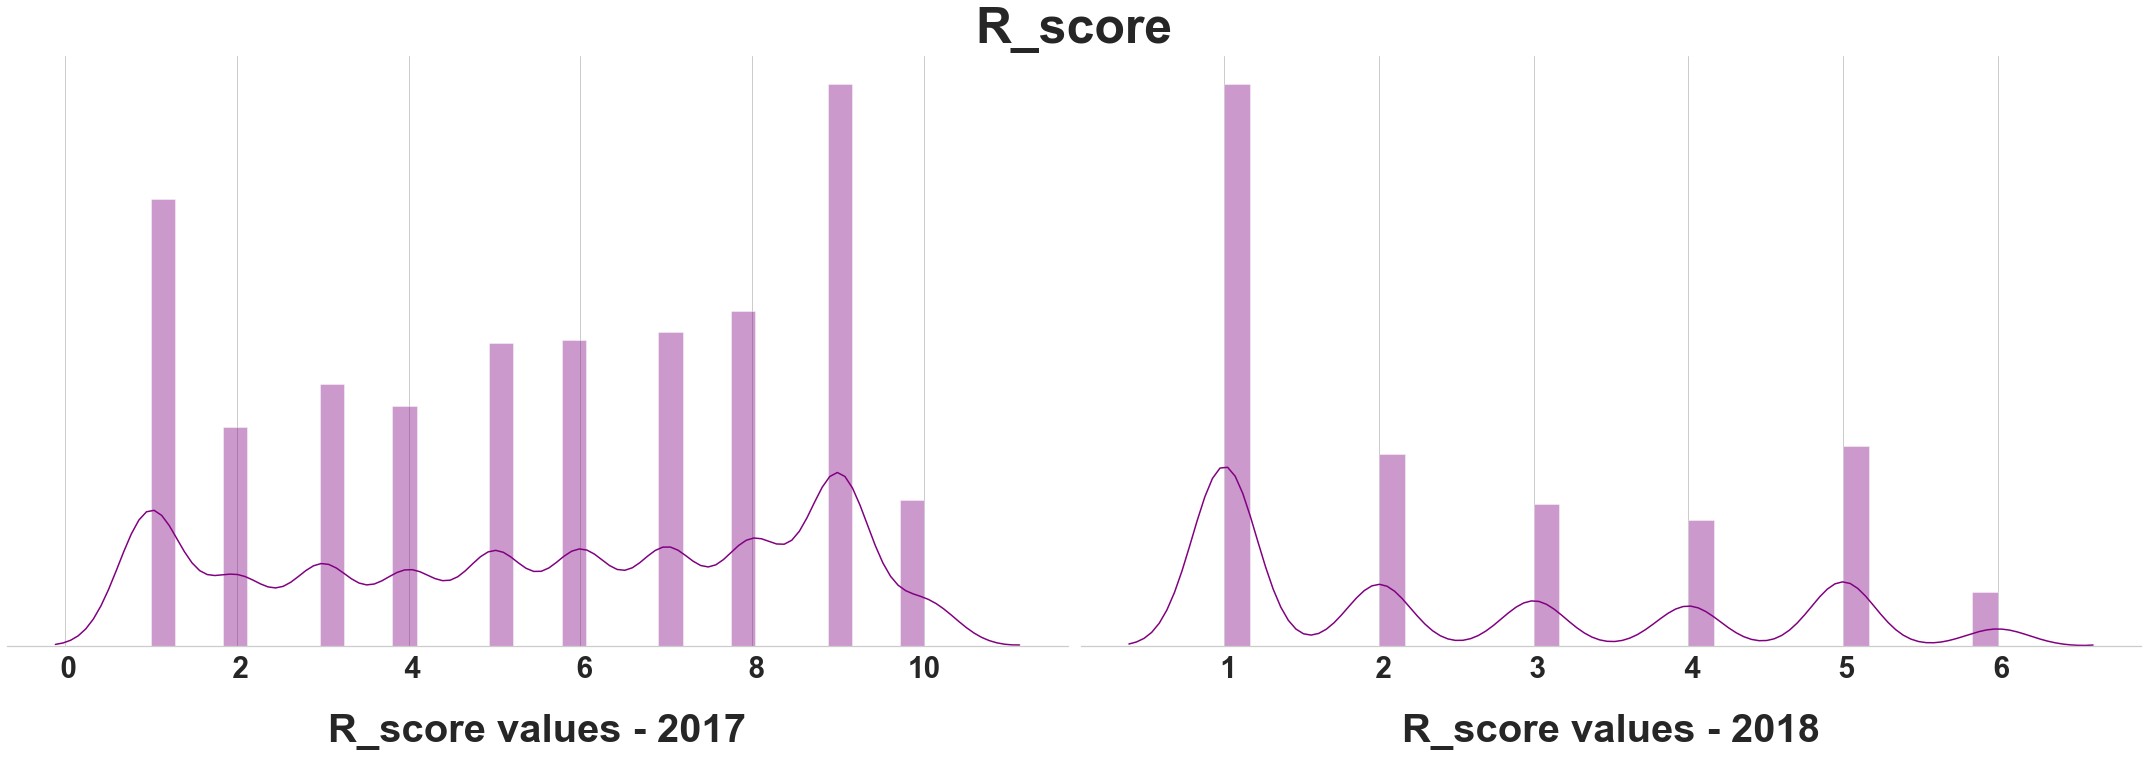

In [80]:
gf.plot_2_discrete_distplots(customer_data_2017,
                             customer_data_2018,
                             "R_score")

_<u>Frequency score</u>_

In [81]:
customer_data["nb_orders"].unique()

array([1])

L'ensemble des clients n'a commandé qu'une fois. Il est donc impossible d'obtenir un distplot des scores de fréquence.

_<u>Monetary score</u>_

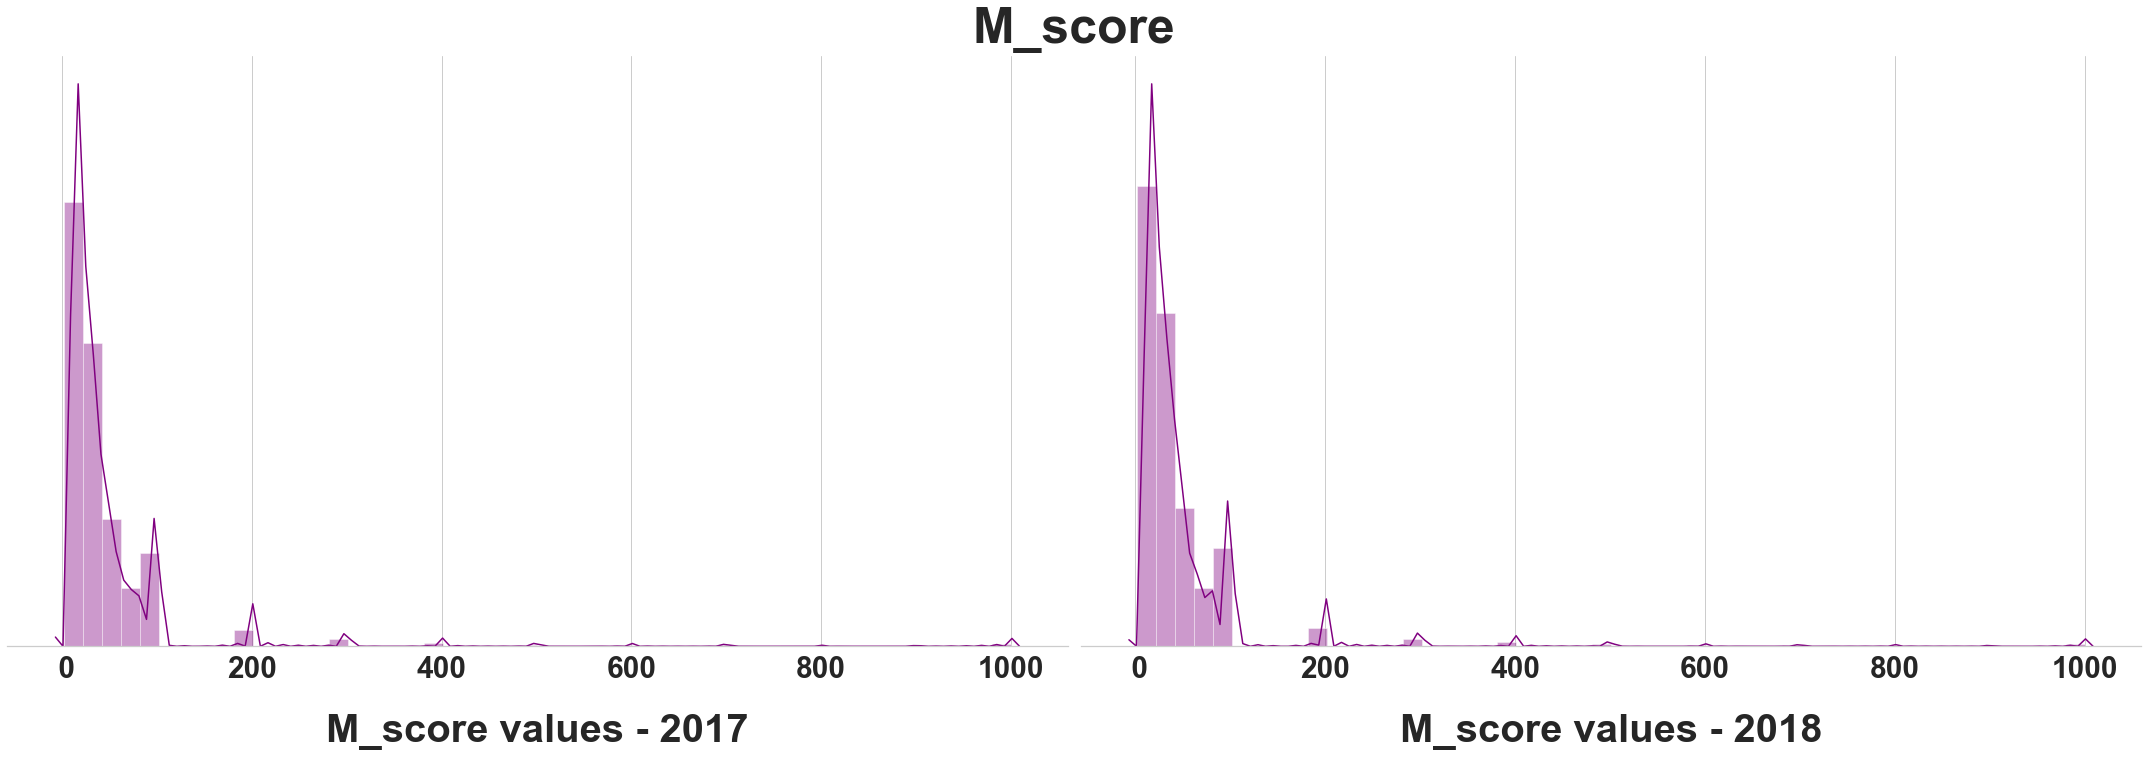

In [82]:
gf.plot_2_discrete_distplots(customer_data_2017,
                             customer_data_2018,
                             "M_score")

Le score de montant semble présenter une distribution relativement stable d'une année à l'autre.

##### _<u>4.3.2 Évolution des commandes</u>_

###### 4.3.2.1 Évolution du nombre de commandes

In [83]:
nb_commandes_2017 = customer_data_2017["nb_orders"].sum()
nb_commandes_2018 = customer_data_2018["nb_orders"].sum()

In [84]:
print("Les {} clients ont passé {} commandes en 2017, soit {} commande par client."\
      .format(nb_clients_2017,
              nb_commandes_2017,
              nb_commandes_2017/nb_clients_2017))
print("\n")
print("Les {} clients ont passé {} commandes en 2018, soit {} commande par client."\
      .format(nb_clients_2018,
              nb_commandes_2018,
              nb_commandes_2018/nb_clients_2018))

Les 41083 clients ont passé 41083 commandes en 2017, soit 1.0 commande par client.


Les 46387 clients ont passé 46387 commandes en 2018, soit 1.0 commande par client.


###### 4.3.2.2 Évolution de la répartition des commandes par état

L'ensemble des clients n'ayant passé qu'une unique commande, la répartiition du nombre de commande par état sera la même que celle du nombre de clients par état.
Nous allons donc nous intéresser à la répartition des commandes en termes de panier moyen.

Quel % du CA total représente chaque région ?

In [85]:
CA_total_2017 = customer_data_2017["average_basket"].sum()
CA_state_2017 = customer_data_2017.groupby("customer_state").agg("sum")
CA_state_2017["% of CA - 2017"] = CA_state_2017["average_basket"]\
                                  .apply(lambda x: x*100/CA_total_2017)
CA_state_2017 = CA_state_2017[["% of CA - 2017"]]

In [86]:
CA_total_2018 = customer_data_2018["average_basket"].sum()
CA_state_2018 = customer_data_2018.groupby("customer_state").agg("sum")
CA_state_2018["% of CA - 2018"] = CA_state_2018["average_basket"]\
                                  .apply(lambda x: x*100/CA_total_2018)
CA_state_2018 = CA_state_2018[["% of CA - 2018"]]

In [87]:
CA_state_year = CA_state_2017.join(CA_state_2018)\
                .sort_values(by=["% of CA - 2018",
                                 "% of CA - 2017"],
                             ascending=False)

In [88]:
CA_state_year

% of CA - 2017  % of CA - 2018
customer_state                                
SP                   35.499494       40.750641
RJ                   14.500582       11.832363
MG                   12.160830       11.316289
RS                    5.954018        5.437154
PR                    5.289928        5.434638
SC                    3.775069        4.053655
BA                    3.789734        3.734664
GO                    2.843562        2.356259
DF                    2.214404        2.161152
ES                    1.856873        2.049380
PE                    1.930675        1.685038
CE                    1.691623        1.436382
MT                    1.404561        1.156412
PA                    1.321923        1.046440
PB                    0.717971        0.917687
MA                    0.799366        0.829340
MS                    0.841872        0.774611
PI                    0.609708        0.677447
RN                    0.552657        0.563913
AL                    0.579386        0.396866
SE                    0.466810        0.324686
TO                    0.351223        0.320524
RO                    0.413618        0.269228
AM                    0.151705        0.190523
AP                    0.112295        0.108816
AC                    0.151032        0.092611
RR                    0.019078        0.083279

80% du CA est produit par les clients de 7 états : SP, RJ, MG, RS, PR, SC, BA.

In [89]:
biggest_states = list(CA_state_year.reset_index()\
                      .head(7)["customer_state"])

**Représentation graphique**

In [90]:
CA_state_year = CA_state_year.reset_index()

In [91]:
biggest_data = CA_state_year[CA_state_year["customer_state"]\
                             .isin(biggest_states)].copy()
other_data = CA_state_year[~CA_state_year["customer_state"]\
                            .isin(biggest_states)].copy()

In [92]:
other_data = pd.DataFrame(other_data.sum()).T

In [93]:
other_data["customer_state"] = "OTHER"

In [94]:
CA_states_data = pd.concat([biggest_data, other_data])\
                 .reset_index(drop=True)

In [95]:
CA_states_data

customer_state % of CA - 2017 % of CA - 2018
0             SP        35.4995        40.7506
1             RJ        14.5006        11.8324
2             MG        12.1608        11.3163
3             RS        5.95402        5.43715
4             PR        5.28993        5.43464
5             SC        3.77507        4.05366
6             BA        3.78973        3.73466
7          OTHER        19.0303        17.4406

In [104]:
data_2017 = CA_states_data[["customer_state", "% of CA - 2017"]]\
            .set_index("customer_state")
data_2018 = CA_states_data[["customer_state", "% of CA - 2018"]]\
            .set_index("customer_state")

gf.plot_2_pie_charts(data_2017, data_2018, 20, 10, "Répartition CA")

###### 4.3.2.3 Évolution de la répartition des catégories commandes par état

In [97]:
data_to_plot = {}

In [98]:
counter = 0

for data in [customer_data_2017, customer_data_2018]:

    data_nb_purchase_cat = pd.DataFrame()

    for customer_state, data_df in customer_data_2017.groupby("customer_state"):

        for product_category, data_state_category in data_df.groupby("product_category_name"):

            data_nb_purchase_cat.loc[customer_state,
                                     product_category] = len(data_state_category)*100/len(data_df)

    data_nb_purchase_cat.fillna(0, inplace=True)

    data_to_plot[counter] = data_nb_purchase_cat.cumsum(axis=1)

    counter += 1

_<u>Année 2017</u>_

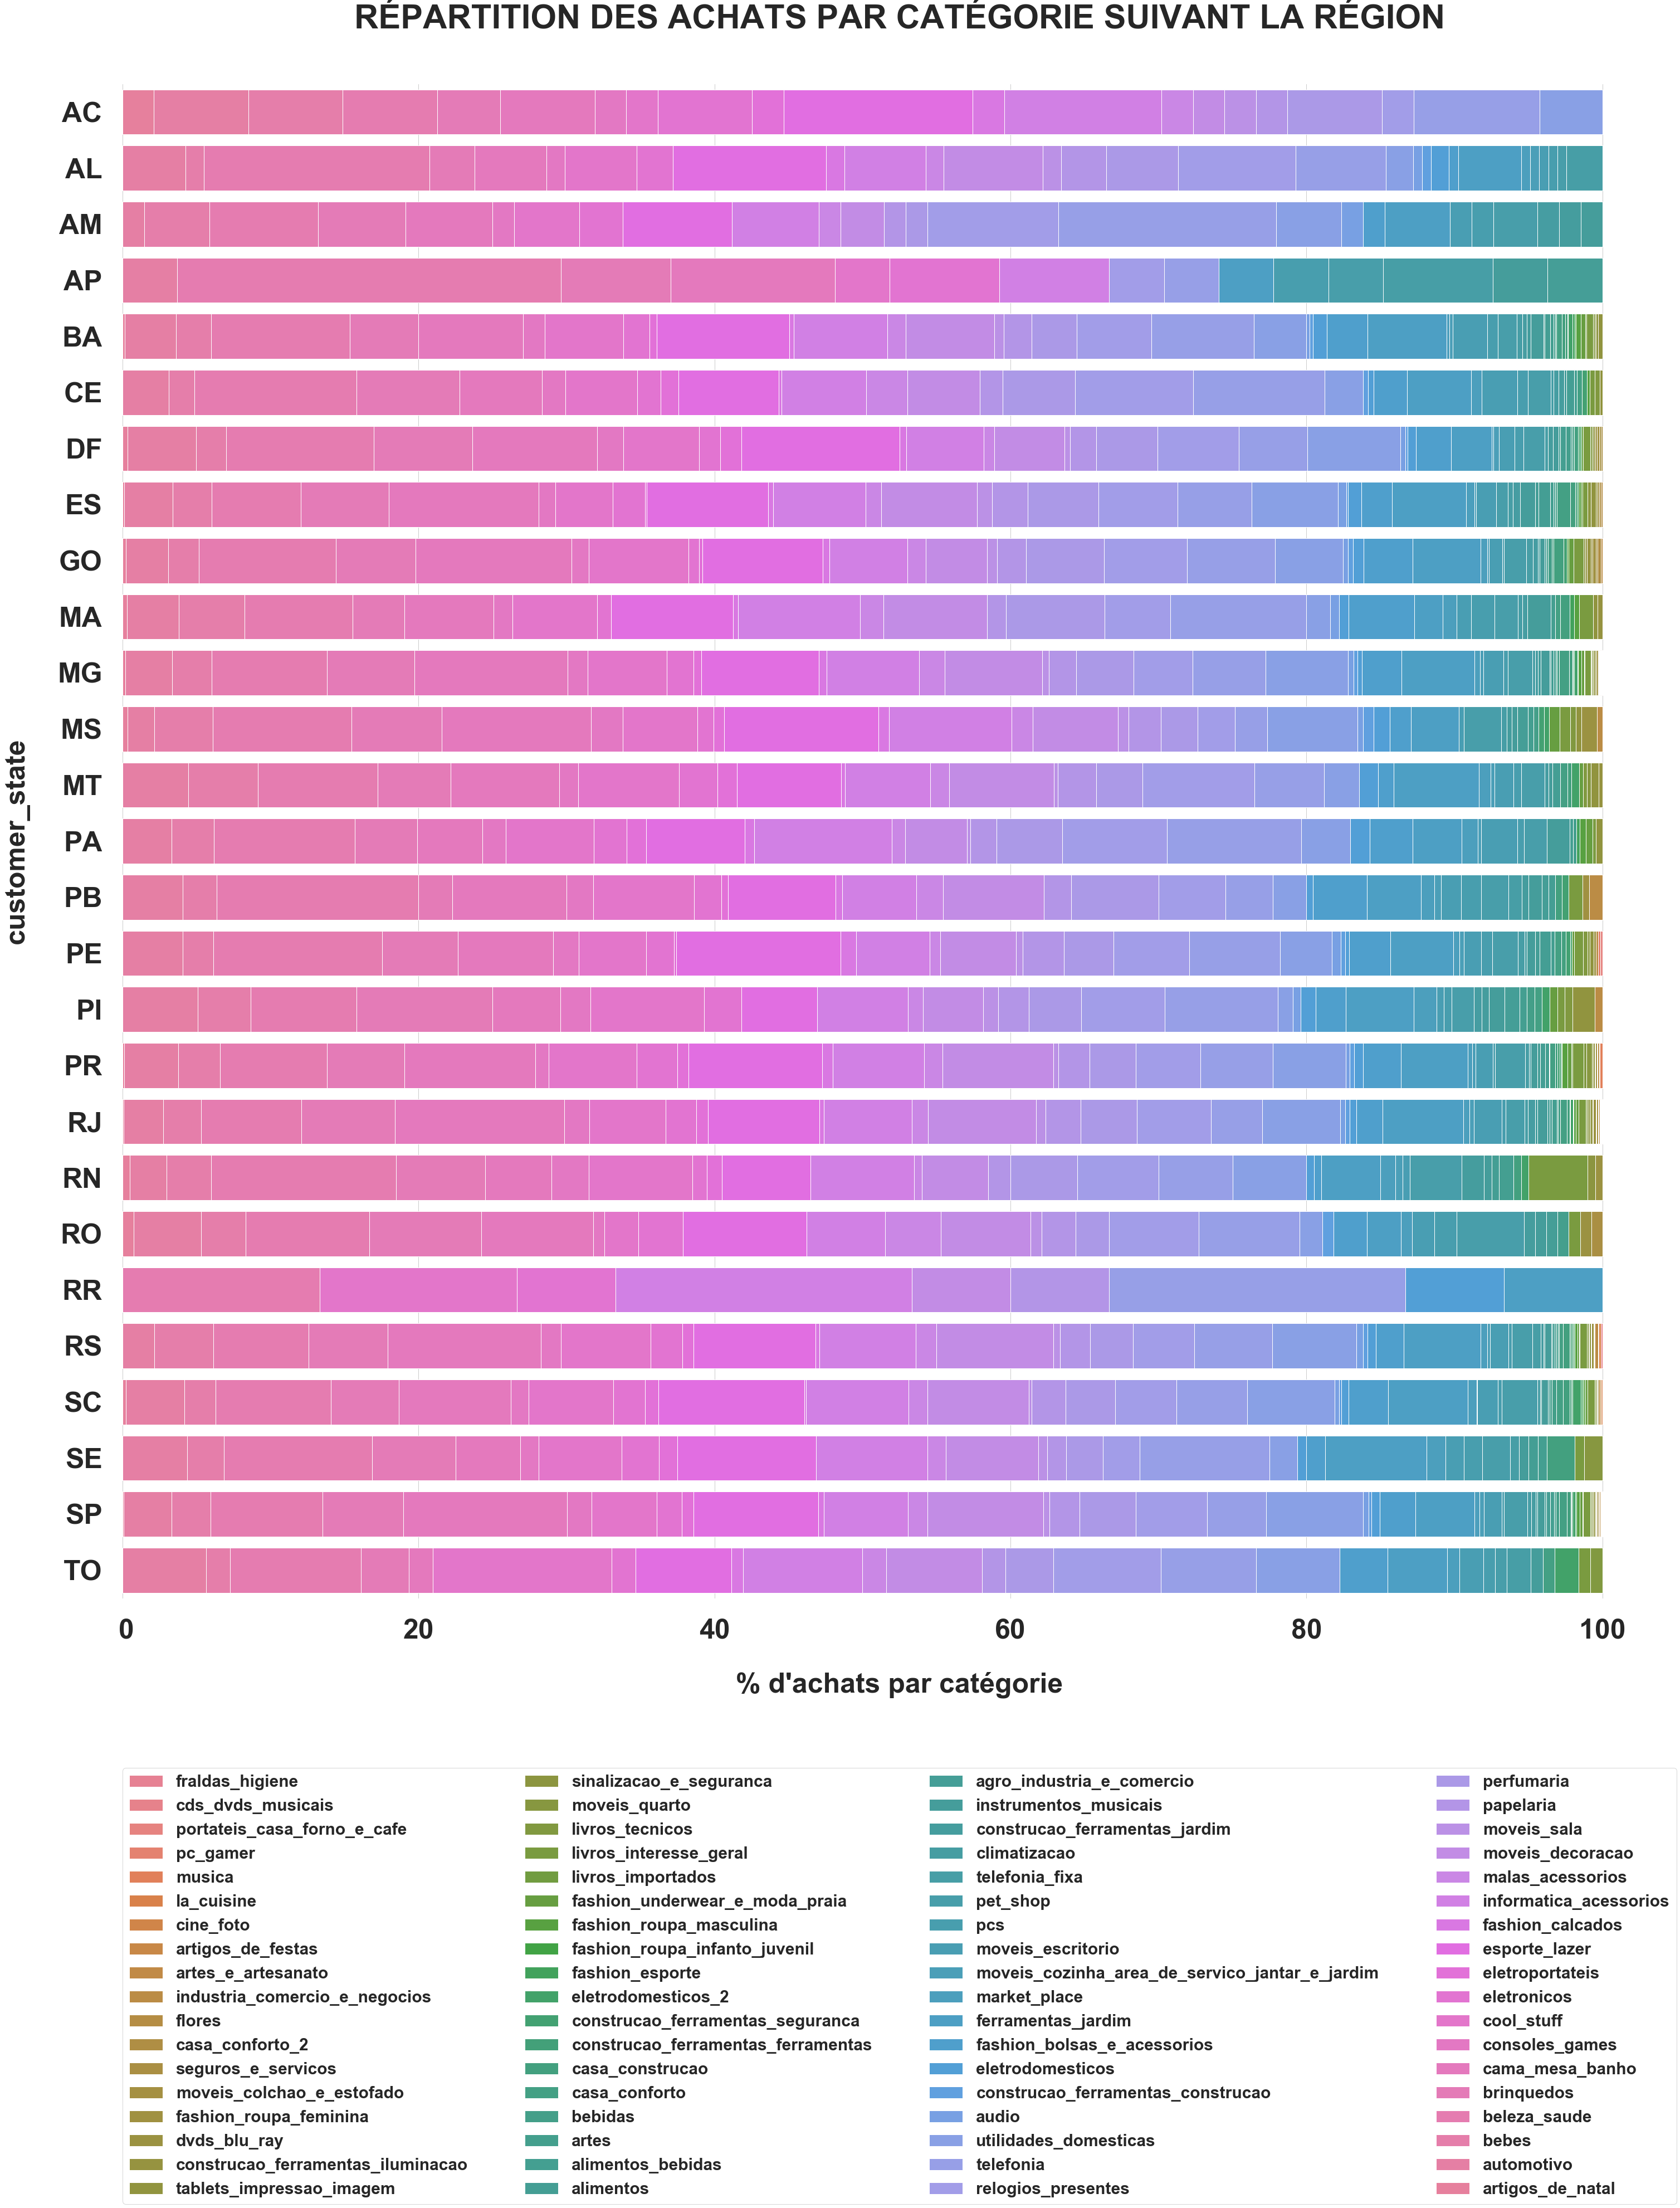

In [99]:
gf.plot_purchase_category_proportions_for_state(data_to_plot[0], 50, 50)

_<u>Année 2018</u>_

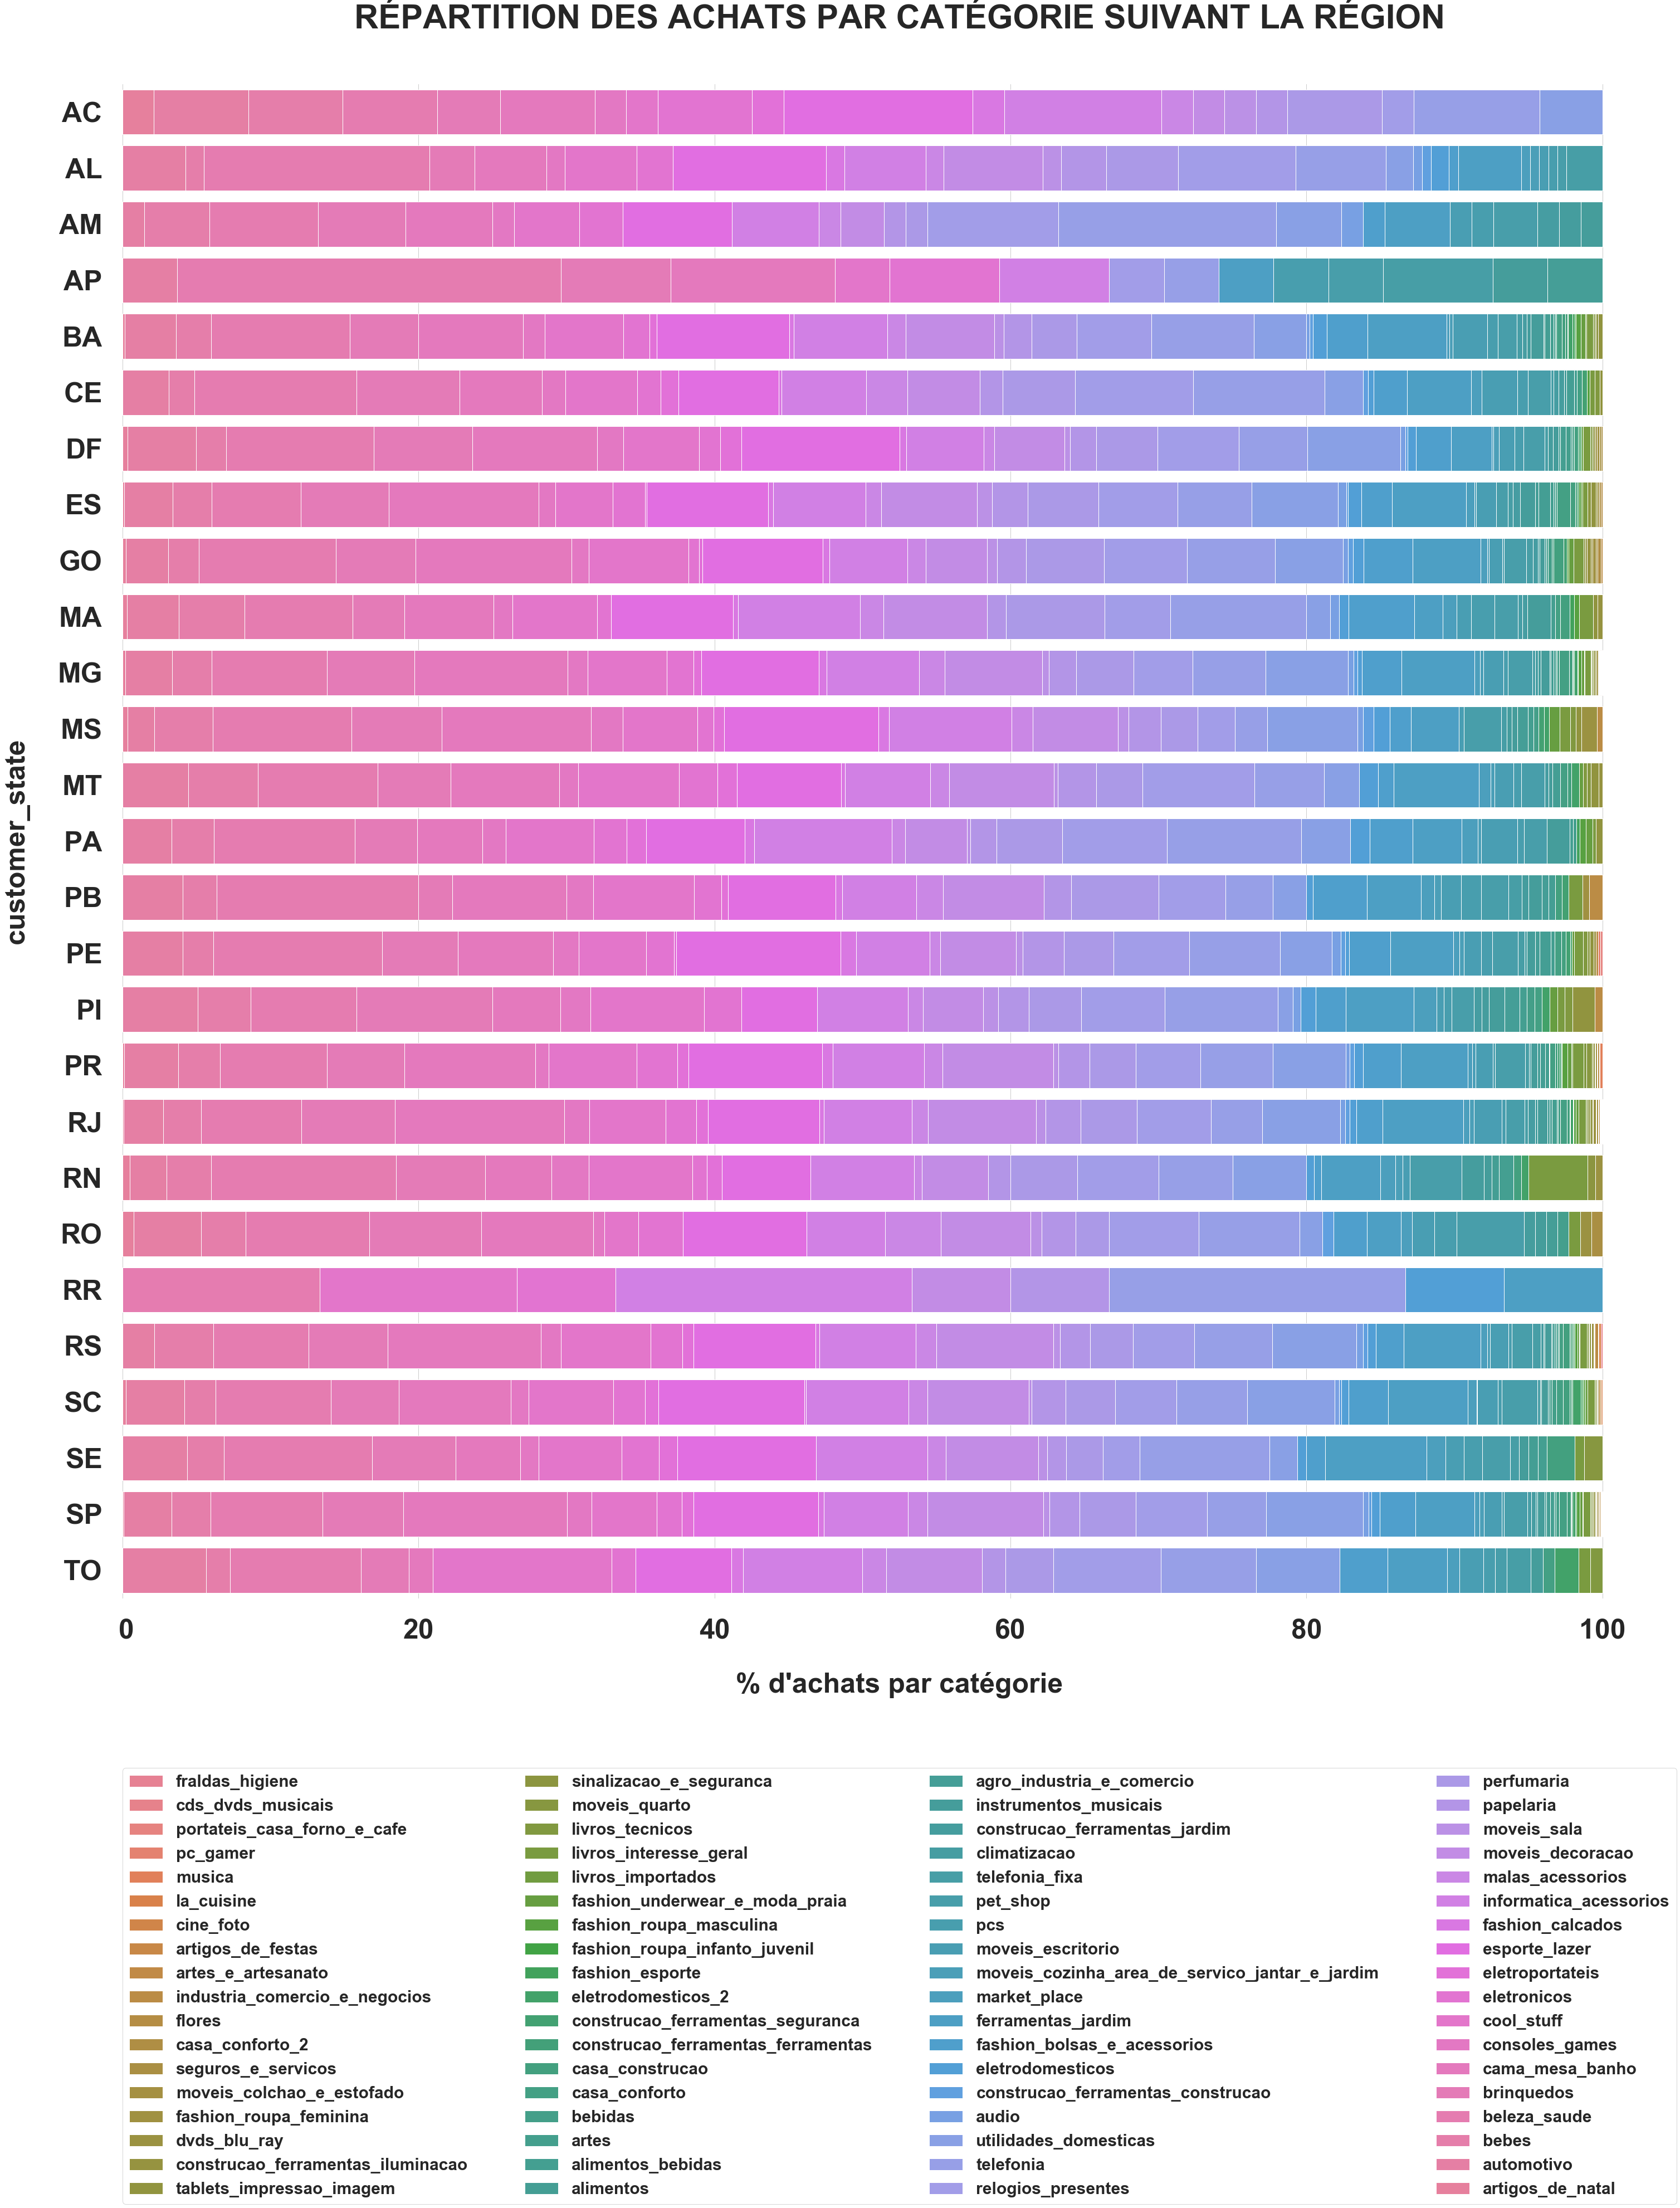

In [100]:
gf.plot_purchase_category_proportions_for_state(data_to_plot[1], 50, 50)

___
### 5. EXPORT DES DONNÉES

In [101]:
customer_data_2017.to_csv("./Resources/datasets/customer_data_2017-cleaned.csv")

In [102]:
customer_data_2018.to_csv("./Resources/datasets/customer_data_2018-cleaned.csv")

___
### 6. CONCLUSION

Le jeu de données est bien renseigné. 

Toutefois, le fait que l'écrasante majorité des clients n'aient effectué qu'un seul achat pose des problèmes pour ce qui est de faire ressortir des habitudes d'achat par des méthodes traditionnelles.

Nous allons donc essayer une approche non supervisée.